In [249]:
# 파일이름 : LAB_data_generator.ipynb|
# 코드설명 : 고무 배합비와 연구소 검사 데이터에 대한 전처리 및 모델 학습 데이터 세트 생성
# 입/출력 : 배합정보, LAB 검사결과, 원재료코드분류 / LAB 데이터 세트(7개)"
# 최종수정 : 2023년 11월 23일
# 제 작 자 : 홍민성 (mshong@micube.co.kr), 맹영준 (myj6223@micube.co.kr)
# Copyright : MICUBE Solution, Inc.

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
#print(font_list)

# 한글 폰트 설정
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False # 유니코드 마이너스 사용 설정 (깨지는 문제 방지)

sns.set(font="NanumGothic", # 일반적으로 설치되어 있는 폰트로 변경
        rc={"axes.unicode_minus": False, "figure.figsize": (20, 8)}, # figure size와 unicode_min
        style='darkgrid',
        font_scale=0.8) # 폰트 크기 설정 추가

import pandas as pd
import numpy as np
import matplotlib
import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')
pd.set_option("display.max_columns", 500)
pd.set_option('display.max_rows', 50)
import os
import koreanize_matplotlib
import pingouin as pg
from tqdm.auto import tqdm

## 1. 데이터 로드 및 통합

### 1) 데이터 로드

In [251]:
lab_recipe_df=pd.read_csv('./dataset/sfitapp_recipe_lab.csv', encoding='cp949')           # 배합비 데이터
lab_insp_df=pd.read_csv('./dataset/sfitapp_insp_lab.csv', encoding='cp949')         # 검사 데이터
lar_cd_df=pd.read_excel('./dataset/jrcode_230907_fin.xlsx')             # 원재료 코드 및 분류표

mes_full_df=pd.read_pickle('./dataset/24-sfites_real_mix_data_full.pkl')

In [252]:
### 이슈5 변경사항 ###
lab_insp_df['lab_cd'] = lab_insp_df['lab_cd'].str.replace('-','')
lab_insp_df['Combined_rm'] = lab_insp_df['lab_cd'] + '_' + lab_insp_df['test_no']
lab_insp_df.head()

,lab_cd,test_no,insp_pps_hs_std,insp_pps_hs_val,insp_pps_sg_std,insp_pps_sg_val,insp_pps_ts_std,insp_pps_ts_val,insp_pps_eb_std,insp_pps_eb_val,insp_pps_m100_std,insp_pps_m100_val,insp_pps_m200_std,insp_pps_m200_val,insp_pps_m300_std,insp_pps_m300_val,insp_pps_tear_std,insp_pps_tear_val,insp_pps_temp_std,insp_pps_temp_val,insp_pps_mnt_std,insp_pps_mnt_val,insp_pps_vul_std,insp_pps_vul_val,insp_rheo_ts2_std,insp_rheo_ts2_val,insp_rheo_t10_std,insp_rheo_t10_val,insp_rheo_t50_std,insp_rheo_t50_val,insp_rheo_t90_std,insp_rheo_t90_val,insp_rheo_min_std,insp_rheo_min_val,insp_rheo_max_std,insp_rheo_max_val,insp_rheo_temp_std,insp_rheo_temp_val,insp_rheo_mnt_std,insp_rheo_mnt_val,insp_mny_mv_std,insp_mny_mv_val,insp_mny_min_std,insp_mny_min_val,insp_mny_t5_std,insp_mny_t5_val,insp_mny_t15_std,insp_mny_t15_val,insp_mny_t30_std,insp_mny_t30_val,insp_mny_t35_std,insp_mny_t35_val,insp_mny_temp_std,insp_mny_temp_val,insp_mny_mls_std,insp_mny_mls_val,insp_mny_148_std,insp_mny_148_val,insp_htrss_hs_std,insp_htrss_hs_val,insp_htrss_ts_std,insp_htrss_ts_val,insp_htrss_eb_std,insp_htrss_eb_val,insp_htrss_temp_std,insp_htrss_temp_val,insp_htrss_hr_std,insp_htrss_hr_val,insp_comprt_rtchn_std,insp_comprt_rtchn_val,insp_comprt_temp_std,insp_comprt_temp_val,insp_comprt_hr_std,insp_comprt_hr_val,insp_ozres_crk_std,insp_ozres_crk_val,insp_ozres_text_std,insp_ozres_text_val,insp_infld1_hs_std,insp_infld1_hs_val,insp_infld1_ts_std,insp_infld1_ts_val,insp_infld1_eb_std,insp_infld1_eb_val,insp_infld1_vol_std,insp_infld1_vol_val,insp_infld1_temp_std,insp_infld1_temp_val,insp_infld1_hr_std,insp_infld1_hr_val,insp_infld1_sol_std,insp_infld1_sol_val,insp_infld2_hs_std,insp_infld2_hs_val,insp_infld2_ts_std,insp_infld2_ts_val,insp_infld2_eb_std,insp_infld2_eb_val,insp_infld2_vol_std,insp_infld2_vol_val,insp_infld2_temp_std,insp_infld2_temp_val,insp_infld2_hr_std,insp_infld2_hr_val,insp_infld2_sol_std,insp_oth_text1_val,insp_oth_text1_val.1,insp_oth_text2_val,insp_oth_text2_val.1,insp_oth_text3_val,insp_oth_text3_val.1,insp_oth_text4_val,insp_oth_text4_val.1,insp_oth_text5_val,insp_oth_text5_val.1,Combined_rm
0,0000QA001,T001,60~65,NaN,1.7↓,NaN,180,NaN,300,NaN,NaN,NaN,NaN,NaN,100,NaN,NaN,NaN,160,160,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,180,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125,ML,ML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125,NaN,72,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000QA001_T001
1,0000QY001,K001,98~100(50~60),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170,170,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,180,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125,ML,ML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000QY001_K001
2,0000QY001,k002,98~100(50~60),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170,170,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,180,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125,ML,ML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0000QY001_k002
3,0000QY001,T001,98~100(50~60),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170,170,10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180,180,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.0,125,ML,ML,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [253]:
mes_full_df.head()

,LOTNO,RUBBER,MECHCD,RPM1,RPM2,RPM3,RPM4,RPM5,RPM6,RPM7,RPM8,RPM9,RPM10,RPM11,RPM12,RPM13,RPM14,RPM15,RPM16,RPM17,RPM18,RPM19,RPM20,TEMP1,TEMP2,TEMP3,TEMP4,TEMP5,TEMP6,TEMP7,TEMP8,TEMP9,TEMP10,TEMP11,TEMP12,TEMP13,TEMP14,TEMP15,TEMP16,TEMP17,TEMP18,TEMP19,TEMP20,TIME1,TIME2,TIME3,TIME4,TIME5,TIME6,TIME7,TIME8,TIME9,TIME10,TIME11,TIME12,TIME13,TIME14,TIME15,TIME16,TIME17,TIME18,TIME19,TIME20,JUK1,JUK2,JUK3,JUK4,JUK5,JUK6,JUK7,JUK8,JUK9,JUK10,JUK11,JUK12,JUK13,JUK14,JUK15,JUK16,JUK17,JUK18,JUK19,JUK20,HS,HS_RESULT,SG,SG_RESULT,TS,TS_RESULT,EB,EB_RESULT,MNY_MIN,MNY_T5,MNY_T35,MNY_RESULT,REHO_MIN,REHO_MAX,REHO_TS2,REHO_TC90,REHO_RESULT,1_JRCODE,2_JRCODE,3_JRCODE,4_JRCODE,5_JRCODE,6_JRCODE,7_JRCODE,8_JRCODE,9_JRCODE,10_JRCODE,11_JRCODE,12_JRCODE,13_JRCODE,14_JRCODE,15_JRCODE,16_JRCODE,17_JRCODE,18_JRCODE,19_JRCODE,20_JRCODE,21_JRCODE,1_PHR,2_PHR,3_PHR,4_PHR,5_PHR,6_PHR,7_PHR,8_PHR,9_PHR,10_PHR,11_PHR,12_PHR,13_PHR,14_PHR,15_PHR,16_PHR,17_PHR,18_PHR,19_PHR,20_PHR,21_PHR,1_PUTGB,2_PUTGB,3_PUTGB,4_PUTGB,5_PUTGB,6_PUTGB,7_PUTGB,8_PUTGB,9_PUTGB,10_PUTGB,11_PUTGB,12_PUTGB,13_PUTGB,14_PUTGB,15_PUTGB,16_PUTGB,17_PUTGB,18_PUTGB,19_PUTGB,20_PUTGB,21_PUTGB,1_PUTORDER,2_PUTORDER,3_PUTORDER,4_PUTORDER,5_PUTORDER,6_PUTORDER,7_PUTORDER,8_PUTORDER,9_PUTORDER,10_PUTORDER,11_PUTORDER,12_PUTORDER,13_PUTORDER,14_PUTORDER,15_PUTORDER,16_PUTORDER,17_PUTORDER,18_PUTORDER,19_PUTORDER,20_PUTORDER,21_PUTORDER,HS_TIME,SG_TIME,TS_TIME,EB_TIME,HS_TEMP,SG_TEMP,TS_TEMP,EB_TEMP,REHO_TIME,REHO_TEMP,MNY_TIME,MNY_TEMP
0,G0116H220037004,1701-A1.01-C1,B-1-01,1198.0,1204.0,1203.0,1203.0,1203.0,1202.0,1205.0,1207.0,1203.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.3,72.7,60.7,75.2,66.2,66.5,67.4,150.3,140.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.4,12.5,27.9,34.3,52.7,14.2,6.0,48.8,16.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,29.0,48.0,95.0,232.0,61.0,22.0,136.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE002,EE004,CB001,CB011,CV001,CG001,CB003,FF001,OP008,NN045,OP008,NN045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.2,35.1,0.60,1.35,0.033,6.000,3.000,36.40,26.89,57.60,24.78,30.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,4.0,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,10.0,10.0,10.0,160.0,160.0,160.0,160.0,5.0,180.0,NaN,NaN
1,G0116H230002003,1454-A2.00-C1,B-1-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE007,EE015A,EE043Z,NN045,OP004,CB011,CB001,CC014,CB009,CD019,OP004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.4,25.0,25.00,0.00,0.000,0.751,0.751,1.13,6.01,2.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,G0116H230002007,1454-A2.00-C1,B-1-01,819.0,820.0,820.0,820.0,820.0,1205.0,1205.0,1204.0,1203.0,1204.0,1203.0,1203.0,1203.0,1203.0,1203.0,0.0,0.0,0.0,0.0,0.0,125.5,69.8,70.6,79.6,71.0,100.0,110.2,119.7,126.3,149.5,141.0,137.6,130.8,159.2,143.7,0.0,0.0,0.0,0.0,0.0,12.0,45.4,8.3,44.1,33.5,30.4,10.6,27.1,8.6,41.3,21.1,24.3,20.6,128.2,16.8,0.0,0.0,0.0,0.0,0.0,7.0,76.0,10.0,194.0,64.0,68.0,0.0,41.0,12.0,75.0,79.0,125.0,103.0,1266.0,51.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EE007,EE015A,EE043Z,NN045,OP004,CB011,CB001,CC014,CB009,CD019,OP004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.3,25.0,25.00,56.00,47.070,0.751,0.751,1.13,6.01,2.25,13.17,NaN,NaN,NaN,NaN,NaN,NaN,N

### 2) LAB, MES 데이터 상 공통 변수 선정 및 컬럼명 통일

In [254]:
trg_regression_cols = ['pps_hs','pps_sg','pps_ts','pps_eb','pps_temp','pps_mnt','MNY','RHeO']
trg_lab_cols = [col for col in lab_insp_df.columns if 
                (len([inCol for inCol in trg_regression_cols if inCol.lower() in col]) != 0) 
                and ("std" not in col) and ("mny_mls" not in col) and ("mny_mv" not in col) and ("mny_t15" not in col) and ("mny_t30" not in col)
                and ("rheo_t10" not in col) and ("rheo_t50" not in col) and ("mny_t30" not in col)]
trg_lab_cols.sort()
print(len(trg_lab_cols), trg_lab_cols)
lab_df = lab_insp_df[trg_lab_cols]
lab_df.rename(columns={'insp_mny_148_val':'MNY_TIME', 'insp_mny_min_val':'MNY_MIN', 'insp_mny_t35_val':'MNY_T35', 'insp_mny_t5_val':'MNY_T5', 'insp_mny_temp_val':'MNY_TEMP', 
'insp_pps_eb_val':'EB', 'insp_pps_hs_val':'HS', 'insp_pps_sg_val':'SG', 'insp_pps_ts_val':'TS', 'insp_rheo_max_val':'REHO_MAX', 'insp_pps_temp_val':'PPS_TEMP', 'insp_pps_mnt_val':'PPS_TIME', 
'insp_rheo_min_val':'REHO_MIN', 'insp_rheo_mnt_val':'REHO_TIME', 'insp_rheo_t90_val':'REHO_TC90', 'insp_rheo_temp_val':'REHO_TEMP', 'insp_rheo_ts2_val':'REHO_TS2'}, errors="raise", inplace=True)
lab_df

17 ['insp_mny_148_val', 'insp_mny_min_val', 'insp_mny_t35_val', 'insp_mny_t5_val', 'insp_mny_temp_val', 'insp_pps_eb_val', 'insp_pps_hs_val', 'insp_pps_mnt_val', 'insp_pps_sg_val', 'insp_pps_temp_val', 'insp_pps_ts_val', 'insp_rheo_max_val', 'insp_rheo_min_val', 'insp_rheo_mnt_val', 'insp_rheo_t90_val', 'insp_rheo_temp_val', 'insp_rheo_ts2_val']


,MNY_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,EB,HS,PPS_TIME,SG,PPS_TEMP,TS,REHO_MAX,REHO_MIN,REHO_TIME,REHO_TC90,REHO_TEMP,REHO_TS2
0,NaN,NaN,NaN,NaN,125,NaN,NaN,10,NaN,160,NaN,NaN,NaN,5,NaN,180,NaN
1,NaN,NaN,NaN,NaN,125,NaN,NaN,10,NaN,170,NaN,NaN,NaN,5,NaN,180,NaN
2,NaN,NaN,NaN,NaN,125,NaN,NaN,10,NaN,170,NaN,NaN,NaN,5,NaN,180,NaN
3,NaN,NaN,NaN,NaN,125,NaN,NaN,10,NaN,170,NaN,NaN,NaN,5,NaN,180,NaN
4,NaN,NaN,NaN,NaN,125,NaN,NaN,10,NaN,170,NaN,NaN,NaN,5,NaN,180,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,NaN,NaN,NaN,NaN,125,NaN,NaN,10,NaN,170,NaN,NaN,NaN,5,NaN,180,NaN
7434,NaN,37.6,70:14:00,0:45:54,NaN,687,55,NaN,1.154,NaN,44,16.7,8.4,5,0:04:30,180,0:02:22
7435,NaN,34.3,NaN,0:50:53,NaN,388,58,NaN,1.116,NaN,174,10.9,7,5,0:04:32,180,0:02:31
7436,NaN,58.6,33:29:00,0:14:27,NaN,589,69,NaN,1.144,NaN,147,35,6.13.6,5,0:03:38,180,0:01:10


In [255]:
# 공통 검사조건(TIME, TEMP)을 기본물성별로 복제
pps_ls = ['HS','SG','TS','EB']
for pps in pps_ls:    
    lab_df[pps+'_TIME'] = lab_df['PPS_TIME']
    lab_df[pps+'_TEMP'] = lab_df['PPS_TEMP']
lab_df.drop(columns=['PPS_TIME','PPS_TEMP'],inplace=True)
lab_df

,MNY_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,EB,HS,SG,TS,REHO_MAX,REHO_MIN,REHO_TIME,REHO_TC90,REHO_TEMP,REHO_TS2,HS_TIME,HS_TEMP,SG_TIME,SG_TEMP,TS_TIME,TS_TEMP,EB_TIME,EB_TEMP
0,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,180,NaN,10,160,10,160,10,160,10,160
1,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,180,NaN,10,170,10,170,10,170,10,170
2,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,180,NaN,10,170,10,170,10,170,10,170
3,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,180,NaN,10,170,10,170,10,170,10,170
4,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,180,NaN,10,170,10,170,10,170,10,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,NaN,NaN,NaN,NaN,125,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,180,NaN,10,170,10,170,10,170,10,170
7434,NaN,37.6,70:14:00,0:45:54,NaN,687,55,1.154,44,16.7,8.4,5,0:04:30,180,0:02:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7435,NaN,34.3,NaN,0:50:53,NaN,388,58,1.116,174,10.9,7,5,0:04:32,180,0:02:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7436,NaN,58.6,33:29:00,0:14:27,NaN,589,69,1.144,147,35,6.13.6,5,0:03:38,180,0:01:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3) LAB, MES 데이터 통합

In [256]:
trg_regression_cols = ['HS','SG','TS','EB','MNY','REHO']
trg_mes_cols = [col for col in mes_full_df.columns if (len([inCol for inCol in trg_regression_cols if inCol in col]) != 0) and ("RESULT" not in col)]
trg_mes_cols.sort()
print(len(trg_mes_cols), trg_mes_cols)
mes_df = mes_full_df[trg_mes_cols]
mes_df

23 ['EB', 'EB_TEMP', 'EB_TIME', 'HS', 'HS_TEMP', 'HS_TIME', 'MNY_MIN', 'MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2', 'SG', 'SG_TEMP', 'SG_TIME', 'TS', 'TS_TEMP', 'TS_TIME']


,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME
0,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841282,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,1+4,1+4,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
841283,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,1+4,1+4,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
841284,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
841285,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,1+4,1+4,NaN,NaN,NaN,160.0,8.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0


In [257]:
lab_df = lab_df[mes_df.columns]
mes_df['type'] = 'mes'
lab_df['type'] = 'lab'
total_df = pd.concat([lab_df, mes_df], ignore_index=True)
total_df.shape

(848725, 24)

In [258]:
# 각 열의 null 값의 개수를 계산
null_counts = total_df.isnull().sum()

# 각 열의 전체 행 수로 나누고 100을 곱하여 퍼센트로 변환
null_percentages = (null_counts / len(total_df)) * 100
dict(null_percentages)

{'EB': 68.18062387699196,
 'EB_TEMP': 19.276208430292495,
 'EB_TIME': 19.27609060649798,
 'HS': 67.80641550561135,
 'HS_TEMP': 19.276208430292495,
 'HS_TIME': 19.27609060649798,
 'MNY_MIN': 64.21278977289464,
 'MNY_T35': 74.89139591740552,
 'MNY_T5': 74.84332380924327,
 'MNY_TEMP': 78.74246664113818,
 'MNY_TIME': 79.47450587646175,
 'REHO_MAX': 57.24233408936935,
 'REHO_MIN': 57.246811393560925,
 'REHO_TC90': 57.2450440366432,
 'REHO_TEMP': 19.168988777283573,
 'REHO_TIME': 19.17358390526967,
 'REHO_TS2': 57.246693569766414,
 'SG': 52.986656455271145,
 'SG_TEMP': 19.276208430292495,
 'SG_TIME': 19.27609060649798,
 'TS': 68.18062387699196,
 'TS_TEMP': 19.276208430292495,
 'TS_TIME': 19.27609060649798,
 'type': 0.0}

In [259]:
list(mes_df['REHO_TC90'].unique())

[nan,
 205.0,
 220.0,
 166.0,
 189.0,
 158.0,
 173.0,
 187.0,
 201.0,
 216.0,
 180.0,
 167.0,
 190.0,
 141.0,
 111.0,
 177.0,
 242.0,
 213.0,
 179.0,
 0.0,
 235.0,
 211.0,
 143.0,
 154.0,
 233.0,
 207.0,
 202.0,
 165.0,
 151.0,
 157.0,
 225.0,
 147.0,
 195.0,
 163.0,
 238.0,
 131.0,
 152.0,
 236.0,
 133.0,
 149.0,
 181.0,
 116.0,
 123.0,
 184.0,
 134.0,
 135.0,
 162.0,
 125.0,
 146.0,
 169.0,
 148.0,
 193.0,
 144.0,
 178.0,
 142.0,
 117.0,
 145.0,
 172.0,
 231.0,
 208.0,
 237.0,
 139.0,
 186.0,
 168.0,
 150.0,
 132.0,
 171.0,
 174.0,
 200.0,
 234.0,
 229.0,
 226.0,
 198.0,
 230.0,
 223.0,
 130.0,
 160.0,
 128.0,
 129.0,
 204.0,
 138.0,
 127.0,
 140.0,
 274.0,
 182.0,
 188.0,
 232.0,
 221.0,
 175.0,
 137.0,
 210.0,
 284.0,
 159.0,
 164.0,
 393.0,
 320.0,
 289.0,
 153.0,
 119.0,
 250.0,
 206.0,
 227.0,
 209.0,
 121.0,
 287.0,
 244.0,
 155.0,
 156.0,
 161.0,
 176.0,
 247.0,
 219.0,
 124.0,
 240.0,
 239.0,
 194.0,
 345.0,
 214.0,
 192.0,
 170.0,
 196.0,
 217.0,
 197.0,
 224.0,
 218.0,
 248

In [260]:
# def find_non_convertible_values(df):
#     non_convertible_values = {}
#     for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
#         # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
#         temp_series = pd.to_numeric(df[col], errors='coerce')        
#         # NaN이 있는 원래 데이터의 값들을 추출
#         non_convertible = df[col][temp_series.isna() & df[col].notna()]        
#         # 중복을 제거하고 NumPy 배열로 저장
#         non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
#         print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
#     return non_convertible_values

# tmp_df = total_df.copy()
# # 함수 적용
# find_non_convertible_values(tmp_df)

In [261]:
# 원하는 컬럼 선택
columns = ['MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2']

# NaN 값을 포함하지 않는 행만 필터링
filtered_df = lab_df[columns].dropna()
filtered_df

,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2
139,761,0:04:29,125,1+4,15,2.9,0:02:50,180,5,0:01:18
140,996,0:05:03,125,1+4,33.5,13.9,0:02:57,180,5,0:00:56
141,11:24,0:05:17,125,1+4,15.9,6.2,0:02:48,180,5,0:01:42
263,10:02,0:05:40,125,1+4,26.6,3,0:02:04,180,5,0:01:02
264,11:38,0:06:17,125,1+4,26.7,3.5,0:02:06,180,5,0:01:03
...,...,...,...,...,...,...,...,...,...,...
7198,12:43,0:08:31,125,1+4,62.6,24.3,0:03:25,180,5,0:02:44
7199,14:38,0:10:32,125,1+4,58.9,20.1,0:03:34,180,5,0:00:59
7200,14:47,0:10:56,125,1+4,58.1,20.5,0:03:38,180,5,0:01:09
7201,0:14:57,0:09:52,125,1+4,22.06,6.66,0:03:36,180,5,0:01:16


In [262]:
filtered_df['MNY_T35'].unique()

array(['761', '996', '11:24', '10:02', '11:38', '15:40', '0', '1201',
       '1119', '1206', '1449', '14:42', '12:38', '1625', '12:05', '11:32',
       '13:57', '1127', '1224', '1323', '17:50', '1011', '8:09', '10:07',
       '7:55', '13:31', '13:06', '13:19', '13:52', '10:36', '9:48',
       '10:10', '11:02', '11:21', '1036', '10:45', '10:19', '10:31',
       '9:35', '647', '11:46', '11:58', '10:59', '13:46', '1450', '15:25',
       '16:05', '15:10', '452', '571', '592', '806', '8:26', '2223',
       '14:39', '15:17', '1133', '1459', '1507', '14:56', '16:03',
       '15:12', '1159', '10:40', '10:41', '543', '1242', '1005', '909',
       '1131', '644', '10:42', '10:18', '11:03', '14:09', '1405', '1407',
       '2849', '9:32', '7:33', '11:11', '11:23', '11:14', '754', '973',
       '846', '672', '792', '12:03', '695', '7:04', '9:26', '17:38',
       '11:28', '8:16', '472', '496', '583', '561', '10:50', "11:'45",
       '12:17', '1528', '1121', '2256', '7:30', '1434', '10352', '18:21',
 

In [263]:
# 원하는 컬럼 선택
columns = ['MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2']

# NaN 값을 포함하지 않는 행만 필터링
filtered_df = mes_df[columns].dropna()
filtered_df

,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2
9051,470.0,354.0,1+4,1+4,32.10,7.2,187.0000,180.0,5.0,45.0000
9553,712.0,458.0,1+4,1+4,20.90,3.5,167.0000,180.0,5.0,61.0000
10050,739.0,429.0,1+4,1+4,15.40,2.0,190.0000,180.0,5.0,71.0000
10689,501.0,337.0,1+4,1+4,25.00,3.7,177.0000,180.0,5.0,55.0000
11461,630.0,428.0,1+4,1+4,22.50,4.1,179.0000,180.0,5.0,60.0000
...,...,...,...,...,...,...,...,...,...,...
840998,0.0,0.0,1+4,1+4,0.00,0.0,0.0000,180.0,5.0,0.0000
840999,0.0,0.0,1+4,1+4,0.00,0.0,0.0000,180.0,5.0,0.0000
841131,0.0,0.0,1+4,1+4,0.00,0.0,0.0000,180.0,5.0,0.0000
841132,505.0,298.0,1+4,1+4,29.05,4.4,169.4052,180.0,5.0,44.1027


In [264]:
tmb_lab_df = lab_df.copy()

import re

# 연산자 적용 함수
def apply_operator(expression):
    if isinstance(expression, (int, float)):
        return expression
    if re.match("^[0-9+\-*/]+$", expression):
        try:
            return eval(expression)
        except ZeroDivisionError:
            return "Division by zero"
        except Exception as e:
            return str(e)
    else:
        return expression

tmb_lab_df = tmb_lab_df.applymap(apply_operator)

def convert_time(time_str):
    if isinstance(time_str, str):
        try:
            return pd.to_datetime(time_str, format='%H:%M:%S').time()
        except ValueError:
            try:
                return pd.to_datetime(time_str, format='%M:%S').time()
            except ValueError:
                return time_str
    return time_str

tmb_lab_df['MNY_T5'] = tmb_lab_df['MNY_T5'].astype(str).replace('::', ':', regex=False)
tmb_lab_df['MNY_T5'] = tmb_lab_df['MNY_T5'].astype(str).replace(':.', ':', regex=False)
tmb_lab_df['MNY_T5'] = tmb_lab_df['MNY_T5'].astype(str).replace(';', ':', regex=False)
tmb_lab_df['MNY_T5'] = tmb_lab_df['MNY_T5'].astype(str).replace('\t', '', regex=False)
tmb_lab_df['MNY_T5'] = tmb_lab_df['MNY_T5'].astype(str).replace(':.', ':', regex=False)

tmb_lab_df['MNY_T5'] = tmb_lab_df['MNY_T5'].apply(convert_time)


tmb_lab_df['MNY_T35'] = tmb_lab_df['MNY_T35'].astype(str).replace('\'', '', regex=False)
tmb_lab_df['MNY_T35'] = tmb_lab_df['MNY_T35'].astype(str).replace('"', '', regex=False)

import re

def remove_trailing_zeros(value):
    if isinstance(value, str):
        if re.match(r'^\d+:\d+:00$', value):
            return value[:-3]
    return value

tmb_lab_df['MNY_T35'] = tmb_lab_df['MNY_T35'].apply(remove_trailing_zeros)
tmb_lab_df['MNY_T35'] = tmb_lab_df['MNY_T35'].apply(convert_time)

In [265]:
# # 원하는 컬럼 선택
# columns = ['MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2']

# # NaN 값을 포함하지 않는 행만 필터링
# filtered_df = mes_df[columns].dropna()
# filtered_df

In [266]:
# 원하는 컬럼 선택
columns = ['MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2']

# NaN 값을 포함하지 않는 행만 필터링
filtered_df = tmb_lab_df[columns].dropna()
filtered_df

,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2
139,761,00:04:29,125,5,15,2.9,0:02:50,180,5,0:01:18
140,996,00:05:03,125,5,33.5,13.9,0:02:57,180,5,0:00:56
141,00:11:24,00:05:17,125,5,15.9,6.2,0:02:48,180,5,0:01:42
263,00:10:02,00:05:40,125,5,26.6,3,0:02:04,180,5,0:01:02
264,00:11:38,00:06:17,125,5,26.7,3.5,0:02:06,180,5,0:01:03
...,...,...,...,...,...,...,...,...,...,...
7198,00:12:43,00:08:31,125,5,62.6,24.3,0:03:25,180,5,0:02:44
7199,00:14:38,00:10:32,125,5,58.9,20.1,0:03:34,180,5,0:00:59
7200,00:14:47,00:10:56,125,5,58.1,20.5,0:03:38,180,5,0:01:09
7201,00:14:57,00:09:52,125,5,22.06,6.66,0:03:36,180,5,0:01:16


In [267]:
import datetime
def str_time_to_seconds(time_str):
    # 'H:M:S' 형식으로 시도
    time_val = pd.to_datetime(time_str, format='%H:%M:%S', errors='coerce')
    if pd.isna(time_val):
        # 'H:M:S' 형식이 실패하면 'M:S' 형식으로 시도
        time_val = pd.to_datetime(time_str, format='%M:%S', errors='coerce')
        if pd.isna(time_val):
            # 모든 형식이 실패하면 원래 문자열 반환
            return time_str
        else:
            delta = datetime.timedelta(minutes=time_val.minute, seconds=time_val.second)
    else:
        delta = datetime.timedelta(hours=time_val.hour, minutes=time_val.minute, seconds=time_val.second)
    return int(delta.total_seconds())

In [268]:
tmb_lab_df = tmb_lab_df.applymap(str_time_to_seconds)

In [269]:
# 원하는 컬럼 선택
columns = ['MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN', 'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2']

# NaN 값을 포함하지 않는 행만 필터링
filtered_df = tmb_lab_df[columns].dropna()
filtered_df

,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2
139,761,269,125,5,15,2.9,170,180,5,78
140,996,303,125,5,33.5,13.9,177,180,5,56
141,684,317,125,5,15.9,6.2,168,180,5,102
263,602,340,125,5,26.6,3,124,180,5,62
264,698,377,125,5,26.7,3.5,126,180,5,63
...,...,...,...,...,...,...,...,...,...,...
7198,763,511,125,5,62.6,24.3,205,180,5,164
7199,878,632,125,5,58.9,20.1,214,180,5,59
7200,887,656,125,5,58.1,20.5,218,180,5,69
7201,897,592,125,5,22.06,6.66,216,180,5,76


In [270]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

# 함수 적용
find_non_convertible_values(tmb_lab_df)

이상 데이터 비율 : 0.22%	 개수/종류 : 16/9개	 EB
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 EB_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 86/20개	 EB_TIME
이상 데이터 비율 : 1.86%	 개수/종류 : 138/52개	 HS
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 HS_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 86/20개	 HS_TIME
이상 데이터 비율 : 0.65%	 개수/종류 : 48/14개	 MNY_MIN
이상 데이터 비율 : 46.81%	 개수/종류 : 3482/137개	 MNY_T35
이상 데이터 비율 : 39.37%	 개수/종류 : 2928/24개	 MNY_T5
이상 데이터 비율 : 0.04%	 개수/종류 : 3/3개	 MNY_TEMP
이상 데이터 비율 : 0.01%	 개수/종류 : 1/1개	 MNY_TIME
이상 데이터 비율 : 0.11%	 개수/종류 : 8/7개	 REHO_MAX
이상 데이터 비율 : 0.12%	 개수/종류 : 9/8개	 REHO_MIN
이상 데이터 비율 : 0.04%	 개수/종류 : 3/2개	 REHO_TC90
이상 데이터 비율 : 0.27%	 개수/종류 : 20/10개	 REHO_TEMP
이상 데이터 비율 : 0.03%	 개수/종류 : 2/2개	 REHO_TIME
이상 데이터 비율 : 0.16%	 개수/종류 : 12/6개	 REHO_TS2
이상 데이터 비율 : 0.46%	 개수/종류 : 34/27개	 SG
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 SG_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 86/20개	 SG_TIME
이상 데이터 비율 : 0.26%	 개수/종류 : 19/11개	 TS
이상 데이터 비율 : 1.08%	 개수/종류 : 80/14개	 TS_TEMP
이상 데이터 비율 : 1.16%	 개수/종류 : 86/20개	 TS_TIME
이상 데이터 비율 : 100.0%	 개수/종류 :

{'EB': array(['x', '582 / 772', '774 (643)', 'T1 540', 'NG(인장성형안됨)',
        'invalid syntax (<string>, line 1)', '378 (양품DATA)', '미실시',
        '1,076'], dtype=object),
 'EB_TEMP': array(['170℃*10分', '180(180)', '170 (180)', '170 (150)(150)', '170 (150)',
        '170 (x)', '180 (2차180℃)', '190 (발포비중)', '170(발포비중)',
        '180 (후가류 180)', '180 (150)', '오븐 240', '160 / 160', '160 / '],
       dtype=object),
 'EB_TIME': array(['180℃*2HR 후가류',
        'leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<string>, line 1)',
        '6(3hrs)', '15 (4hrs)', '10 (1hrs)(2hrs)', '10 (1hrs)',
        '10 (180*40분 후가류)', '10 (x)', '200초', '10 (2hrs)', '180초',
        '10 (4HR)', '5(2차 4hrs)', '15 (4 HRS)', '10(180*40분 후가류)',
        '8 (후가류 40) -C/SET함께', '8 (4hrs)', '10월 06일', '10월 15일', 'MDR-2'],
       dtype=object),
 'HS': array(['72~73/80', '미실시', '배합 미실시', 'x', '46>47', '41->42(경시)', '52->53',
        '39->40', '38->40', '45->47', '45>46', '4

In [271]:
def replace_non_numeric_with_nan(df):
    for col in df.columns:
        # 컬럼의 데이터 타입이 object인 경우에만 처리
        if df[col].dtype == 'object':
            # 숫자로 변환 가능한지 확인하고, 불가능한 경우 NaN으로 설정
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df
replace_non_numeric_with_nan(tmb_lab_df)

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME,type
0,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0,NaN
1,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,NaN
2,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,NaN
3,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,NaN
4,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7433,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0,NaN
7434,687.0,NaN,NaN,55.0,NaN,NaN,37.6,NaN,2754.0,NaN,NaN,16.7,8.4,270.0,180.0,5.0,142.0,1.154,NaN,NaN,44.0,NaN,NaN,NaN
7435,388.0,NaN,NaN,58.0,NaN,NaN,34.3,NaN,3053.0,NaN,NaN,10.9,7.0,272.0,180.0,5.0,151.0,1.116,NaN,NaN,174.0,NaN,NaN,NaN
7436,589.0,NaN,NaN,69.0,NaN,NaN,58.6,2009.0,867.0,NaN,NaN,35.0,NaN,218.0,180.0,5.0,70.0,1.144,NaN,NaN,147.0,NaN,NaN,NaN


In [272]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

tmp_df = tmb_lab_df.copy()
# 함수 적용
find_non_convertible_values(tmp_df)

{}

In [273]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

tmp_df = mes_df.copy()
# 함수 적용
find_non_convertible_values(tmp_df)

이상 데이터 비율 : 19.33%	 개수/종류 : 162627/1개	 MNY_TEMP
이상 데이터 비율 : 19.33%	 개수/종류 : 162627/1개	 MNY_TIME
이상 데이터 비율 : 100.0%	 개수/종류 : 841287/1개	 type


{'MNY_TEMP': array(['1+4'], dtype=object),
 'MNY_TIME': array(['1+4'], dtype=object),
 'type': array(['mes'], dtype=object)}

In [274]:
total_df = pd.concat([tmb_lab_df, mes_df], ignore_index=True)
total_df.shape

(848725, 24)

In [275]:
# 각 열의 null 값의 개수를 계산
null_counts = tmb_lab_df.isnull().sum()

# 각 열의 전체 행 수로 나누고 100을 곱하여 퍼센트로 변환
null_percentages = (null_counts / len(tmb_lab_df)) * 100
dict(null_percentages)

{'EB': 37.57730572734606,
 'EB_TEMP': 8.6313525141167,
 'EB_TIME': 8.69857488572197,
 'HS': 37.09330465178812,
 'HS_TEMP': 8.6313525141167,
 'HS_TIME': 8.69857488572197,
 'MNY_MIN': 55.33745630545845,
 'MNY_T35': 46.81365958591019,
 'MNY_T5': 39.365420812046246,
 'MNY_TEMP': 7.865017477816617,
 'MNY_TIME': 91.3686474858833,
 'REHO_MAX': 35.81607959128798,
 'REHO_MIN': 36.34041408980909,
 'REHO_TC90': 36.05808012906696,
 'REHO_TEMP': 6.84323742941651,
 'REHO_TIME': 7.125571390158644,
 'REHO_TS2': 36.3673030384512,
 'SG': 37.14708254907233,
 'SG_TEMP': 8.6313525141167,
 'SG_TIME': 8.69857488572197,
 'TS': 37.61763915030922,
 'TS_TEMP': 8.6313525141167,
 'TS_TIME': 8.69857488572197,
 'type': 100.0}

## 2. 결합 데이터 이상치 수정 및 분포 시각화 검토

### 1) Object형 데이터 체크

In [44]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

tmp_df = total_df.copy()
# 함수 적용
find_non_convertible_values(tmp_df)

이상 데이터 비율 : 19.16%	 개수/종류 : 162627/1개	 MNY_TEMP
이상 데이터 비율 : 19.16%	 개수/종류 : 162627/1개	 MNY_TIME


{'MNY_TEMP': array(['1+4'], dtype=object),
 'MNY_TIME': array(['1+4'], dtype=object)}

## 1+5, 6*2 같은 연산자 처리

In [45]:
total_df['MNY_TIME'].tail()

848720    1+4
848721    1+4
848722    NaN
848723    1+4
848724    NaN
Name: MNY_TIME, dtype: object

In [46]:
import re

# 연산자 적용 함수
def apply_operator(expression):
    if isinstance(expression, (int, float)):
        return expression
    
    if re.match("^[0-9+\-*/]+$", expression):
        try:
            return eval(expression)
        except ZeroDivisionError:
            return "Division by zero"
        except Exception as e:
            return str(e)
    else:
        return expression

total_df = total_df.applymap(apply_operator)

In [47]:
total_df['MNY_TIME'].tail()

848720    5.0
848721    5.0
848722    NaN
848723    5.0
848724    NaN
Name: MNY_TIME, dtype: float64

In [48]:
def find_non_convertible_values(df):
    non_convertible_values = {}
    for col in df.select_dtypes(include=['object']).columns:  # object 타입 컬럼만 순회
        # 숫자로 변환을 시도하고, 변환되지 않는 값들은 NaN으로 대체
        temp_series = pd.to_numeric(df[col], errors='coerce')        
        # NaN이 있는 원래 데이터의 값들을 추출
        non_convertible = df[col][temp_series.isna() & df[col].notna()]        
        # 중복을 제거하고 NumPy 배열로 저장
        non_convertible_values[col] = np.array(non_convertible.drop_duplicates(), dtype=object)
        print('이상 데이터 비율 : '+str(np.round(len(non_convertible)/len(df)*100, 2))+'%\t', '개수/종류 : '+str(len(non_convertible))+'/'+str(len(non_convertible_values[col]))+'개\t', col)
    
    return non_convertible_values

total_df = total_df.copy()
# 함수 적용
find_non_convertible_values(total_df)

{}

In [65]:
# 초단위 데이터의 소수점 제거
total_df[['MNY_MIN','MNY_T35', 'MNY_T5', 'MNY_TIME', 'REHO_MAX', 
          'REHO_MIN','REHO_TC90', 'REHO_TIME', 'REHO_TS2']] = np.round(total_df[['MNY_MIN','MNY_T35', 'MNY_T5', 'MNY_TIME', 'REHO_MAX', 
                                                                                 'REHO_MIN', 'REHO_TC90', 'REHO_TIME', 'REHO_TS2']], 0)

In [66]:
total_df.columns

Index(['EB', 'EB_TEMP', 'EB_TIME', 'HS', 'HS_TEMP', 'HS_TIME', 'MNY_MIN',
       'MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN',
       'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2', 'SG', 'SG_TEMP',
       'SG_TIME', 'TS', 'TS_TEMP', 'TS_TIME'],
      dtype='object')

<Axes: >

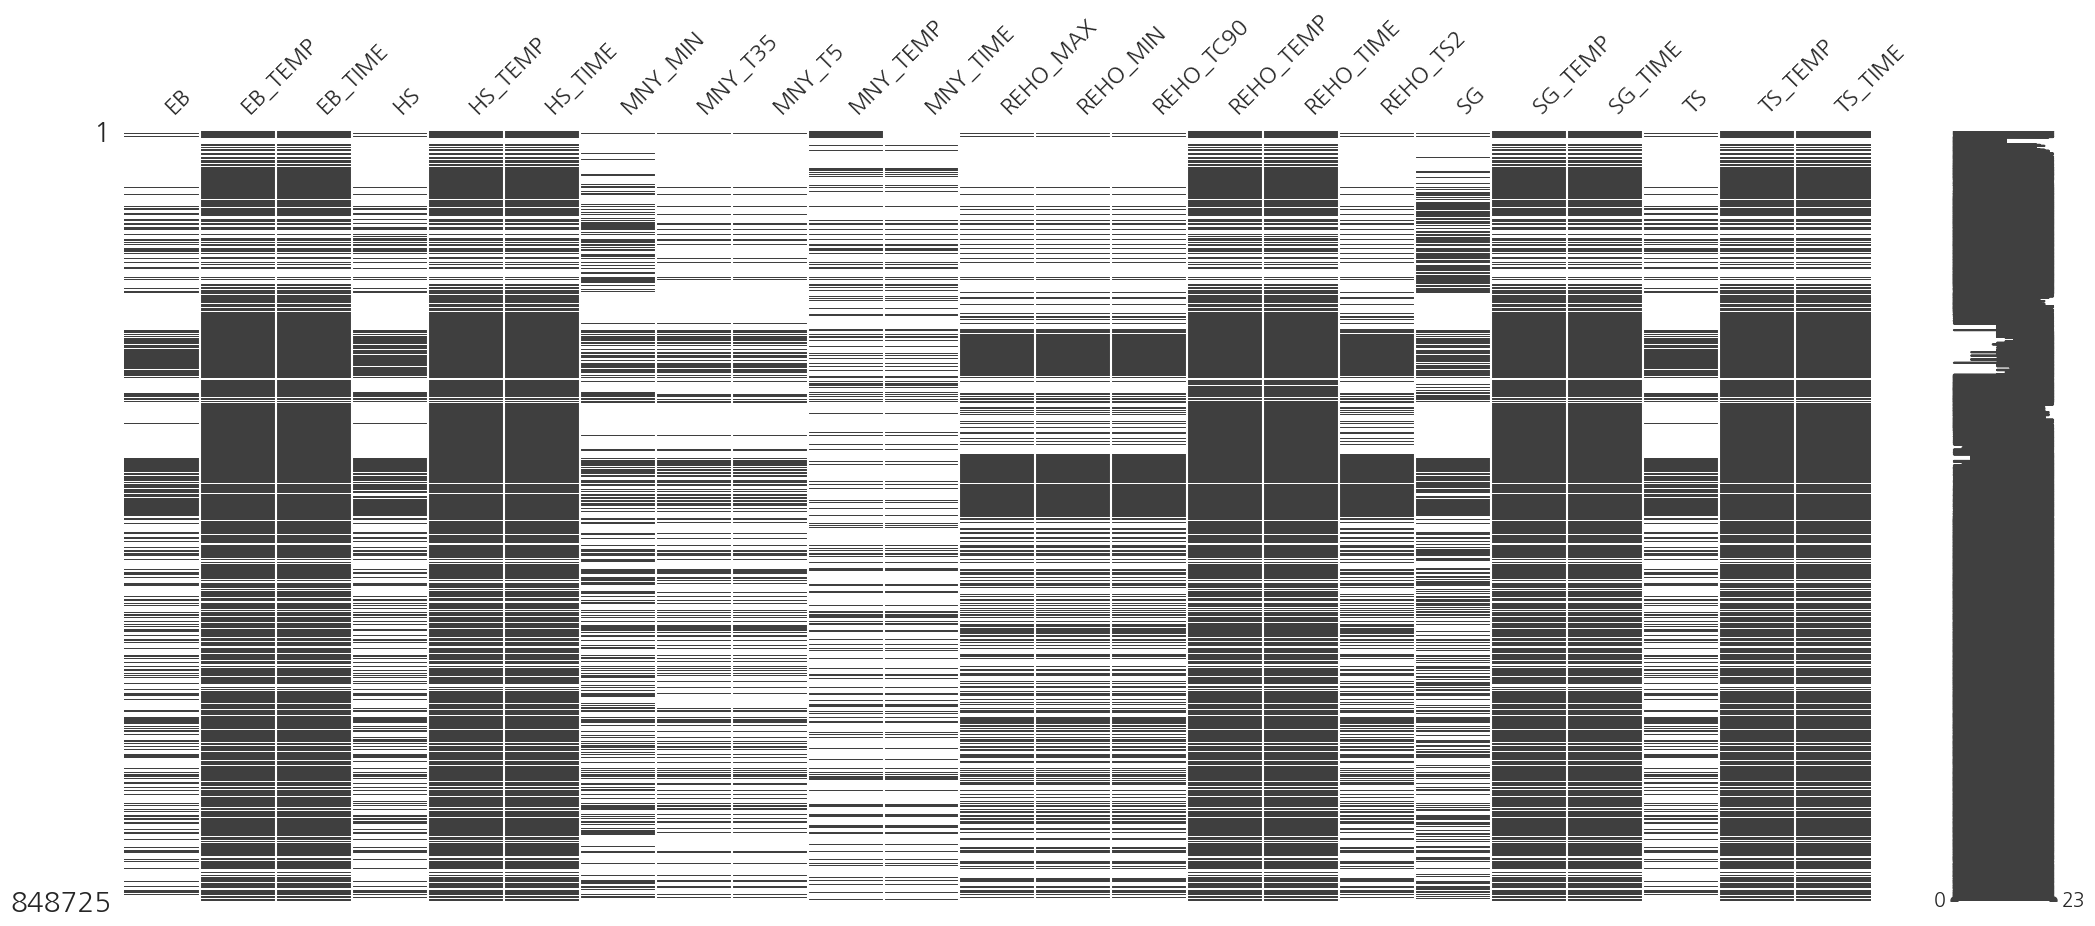

In [53]:
import missingno as msno
msno.matrix(total_df)

<Axes: >

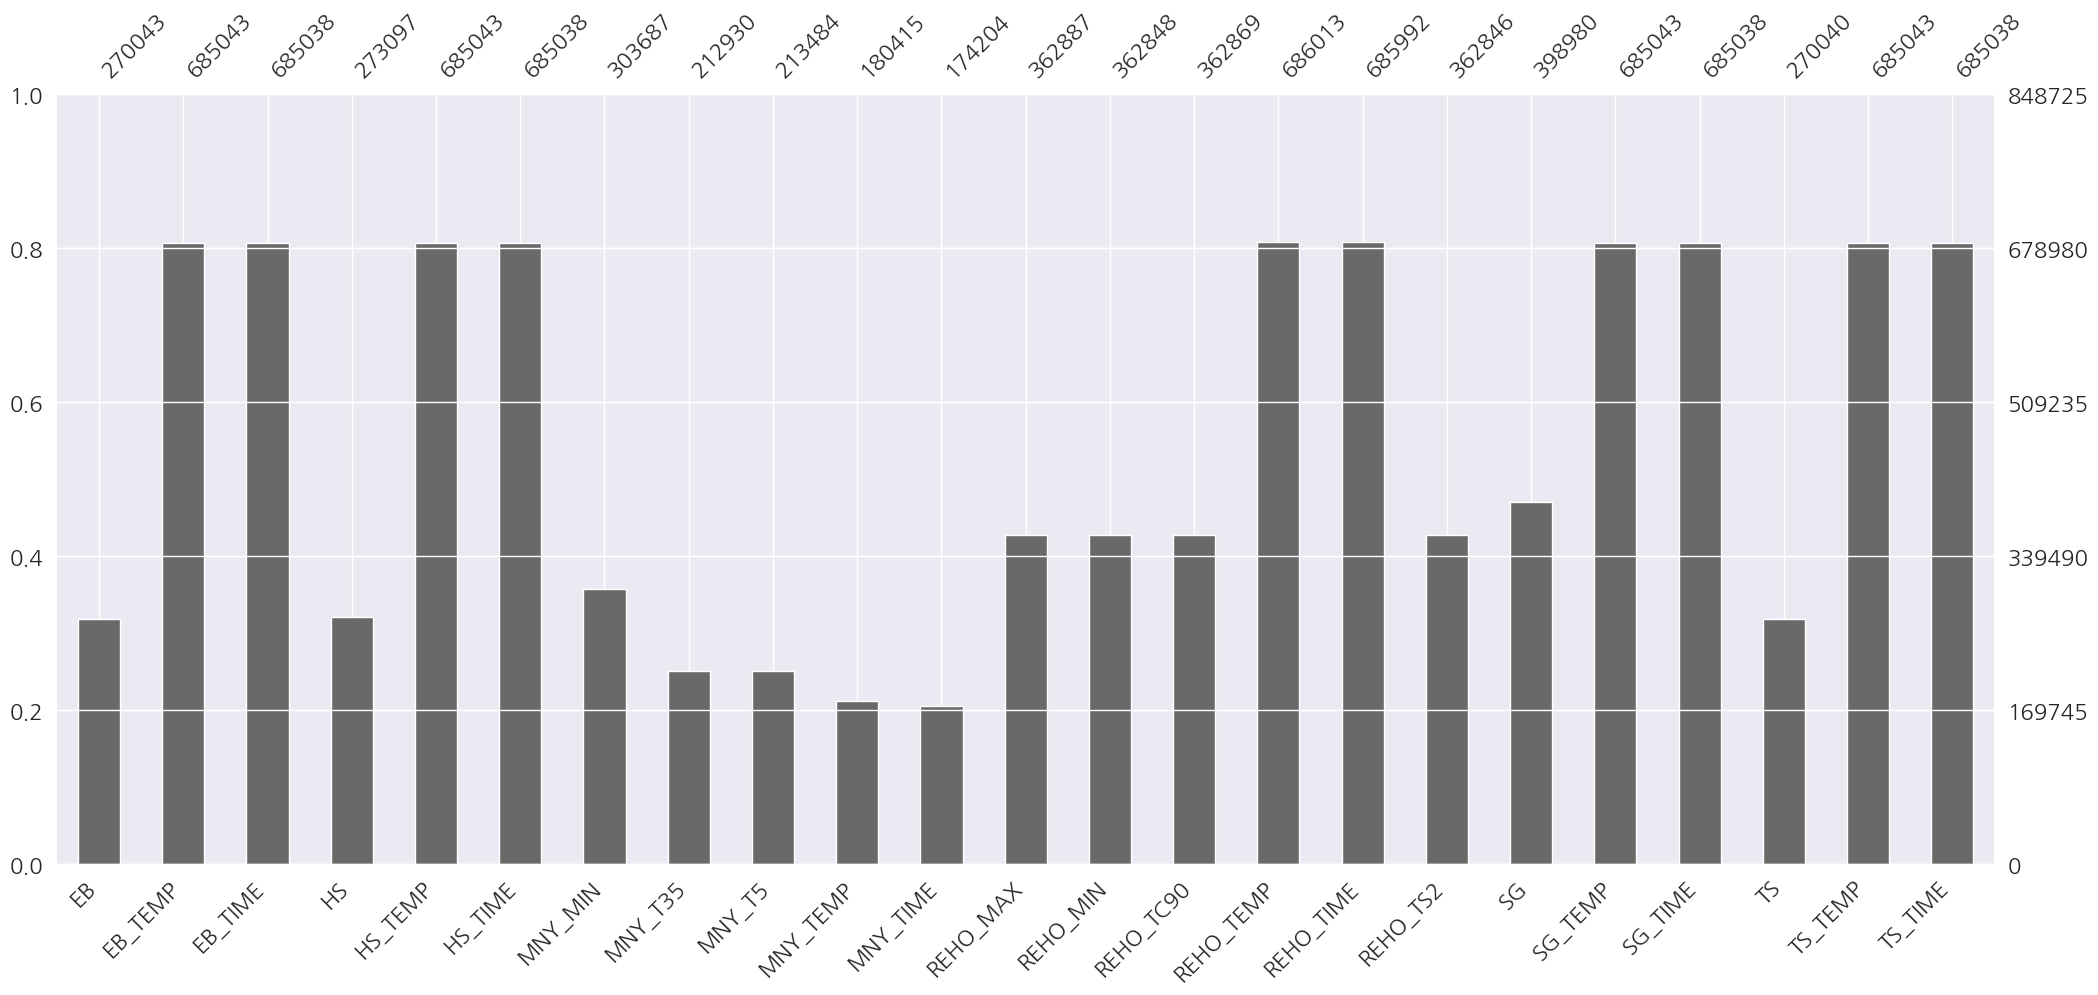

In [78]:
msno.bar(total_df)

In [79]:
# 각 열의 null 값의 개수를 계산
null_counts = total_df.isnull().sum()

# 각 열의 전체 행 수로 나누고 100을 곱하여 퍼센트로 변환
null_percentages = (null_counts / len(total_df)) * 100
dict(null_percentages)

{'EB': 68.1825090577042,
 'EB_TEMP': 19.28563433385372,
 'EB_TIME': 19.2862234528263,
 'HS': 67.82267518925447,
 'HS_TEMP': 19.28563433385372,
 'HS_TIME': 19.2862234528263,
 'MNY_MIN': 64.21844531503137,
 'MNY_T35': 74.91177943385667,
 'MNY_T5': 74.84650505169519,
 'MNY_TEMP': 78.74282011252173,
 'MNY_TIME': 79.47462370025626,
 'REHO_MAX': 57.243276679725476,
 'REHO_MIN': 57.24787180771157,
 'REHO_TC90': 57.24539750802674,
 'REHO_TEMP': 19.17134525317388,
 'REHO_TIME': 19.1738195528587,
 'REHO_TS2': 57.2481074553006,
 'SG': 52.99066246428467,
 'SG_TEMP': 19.28563433385372,
 'SG_TIME': 19.2862234528263,
 'TS': 68.18286252908776,
 'TS_TEMP': 19.28563433385372,
 'TS_TIME': 19.2862234528263}

In [215]:
fin_lab_df = total_df.copy()

In [216]:
fin_lab_df.describe()

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME
count,270043.000000,685043.0000,685038.000000,273097.000000,685043.0000,685038.000000,303687.000000,212930.000000,213484.000000,180415.000000,174204.000000,362887.000000,362848.000000,362869.000000,686013.000000,685992.000000,362846.000000,398980.000000,685043.0000,685038.000000,270040.000000,685043.0000,685038.000000
mean,93.399611,162.6667,10.157246,11.238145,162.6667,10.157246,18.604267,284.258996,258.962358,9.386492,4.752985,21.753474,4.349075,147.714065,177.905423,5.646805,64.638519,0.283791,162.6667,10.157246,24.251084,162.6667,10.157246
std,210.116555,193.3417,6.262181,24.039258,193.3417,6.262181,28.618211,518.931545,416.795402,23.540483,1.217485,13.548232,3.571618,77.738523,30.306709,2.350154,39.540432,0.546192,193.3417,6.262181,53.662966,193.3417,6.262181
min,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.947368,4.000000,0.000000,-0.999000,0.0000,0.000000,0.000000,0.0000,0.000000
25%,0.000000,160.0000,10.000000,0.000000,160.0000,10.000000,0.000000,0.000000,0.000000,5.000000,5.000000,13.000000,2.000000,118.000000,180.000000,5.000000,48.000000,0.000000,160.0000,10.000000,0.000000,160.0000,10.000000
50%,0.000000,160.0000,10.000000,0.000000,160.0000,10.000000,0.000000,0.000000,0.000000,5.000000,5.000000,21.000000,4.000000,149.000000,180.000000,5.000000,62.000000,0.000000,160.0000,10.000000,0.000000,160.0000,10.000000
75%,0.000000,160.0000,10.000000,0.000000,160.0000,10.000000,33.000000,606.000000,478.000000,5.000000,5.000000,33.000000,6.000000,181.000000,180.000000,5.000000,77.000000,0.000000,160.0000,10.000000,0.000000,160.0000,10.000000
max,7006.000000,160107.0000,1700.000000,98.000000,160107.0000,1700.000000,4600.000000,51431.000000,7042.000000,908.000000,145.000000,1291.000000,308.000000,1800.000000,18032.100000,844.000000,702.000000,83.000000,160107.0000,1700.000000,1404.000000,160107.0000,1700.000000


In [217]:
# 치환할 값의 딕셔너리
replace_values = {
    'HS_TIME': 10, 'SG_TIME': 10, 'TS_TIME': 10, 'EB_TIME': 10,
    'HS_TEMP': 170, 'SG_TEMP': 170, 'TS_TEMP': 170, 'EB_TEMP': 170,
    'REHO_TIME': 5, 'REHO_TEMP': 180,
    'MNY_TIME': 5, 'MNY_TEMP': 125
}

# 0 값을 위의 딕셔너리에 정의된 값으로 치환
fin_lab_df.replace({col: {0: val} for col, val in replace_values.items()}, inplace=True)

# 변경 사항을 확인하기 위해 데이터프레임 출력
fin_lab_df

,EB,EB_TEMP,EB_TIME,HS,HS_TEMP,HS_TIME,MNY_MIN,MNY_T35,MNY_T5,MNY_TEMP,MNY_TIME,REHO_MAX,REHO_MIN,REHO_TC90,REHO_TEMP,REHO_TIME,REHO_TS2,SG,SG_TEMP,SG_TIME,TS,TS_TEMP,TS_TIME
0,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
1,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
2,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
3,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
4,NaN,170.0,10.0,NaN,170.0,10.0,NaN,NaN,NaN,125.0,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,170.0,10.0,NaN,170.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848720,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
848721,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
848722,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,5.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0
848723,NaN,160.0,10.0,NaN,160.0,10.0,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,160.0,8.0,NaN,NaN,160.0,10.0,NaN,160.0,10.0


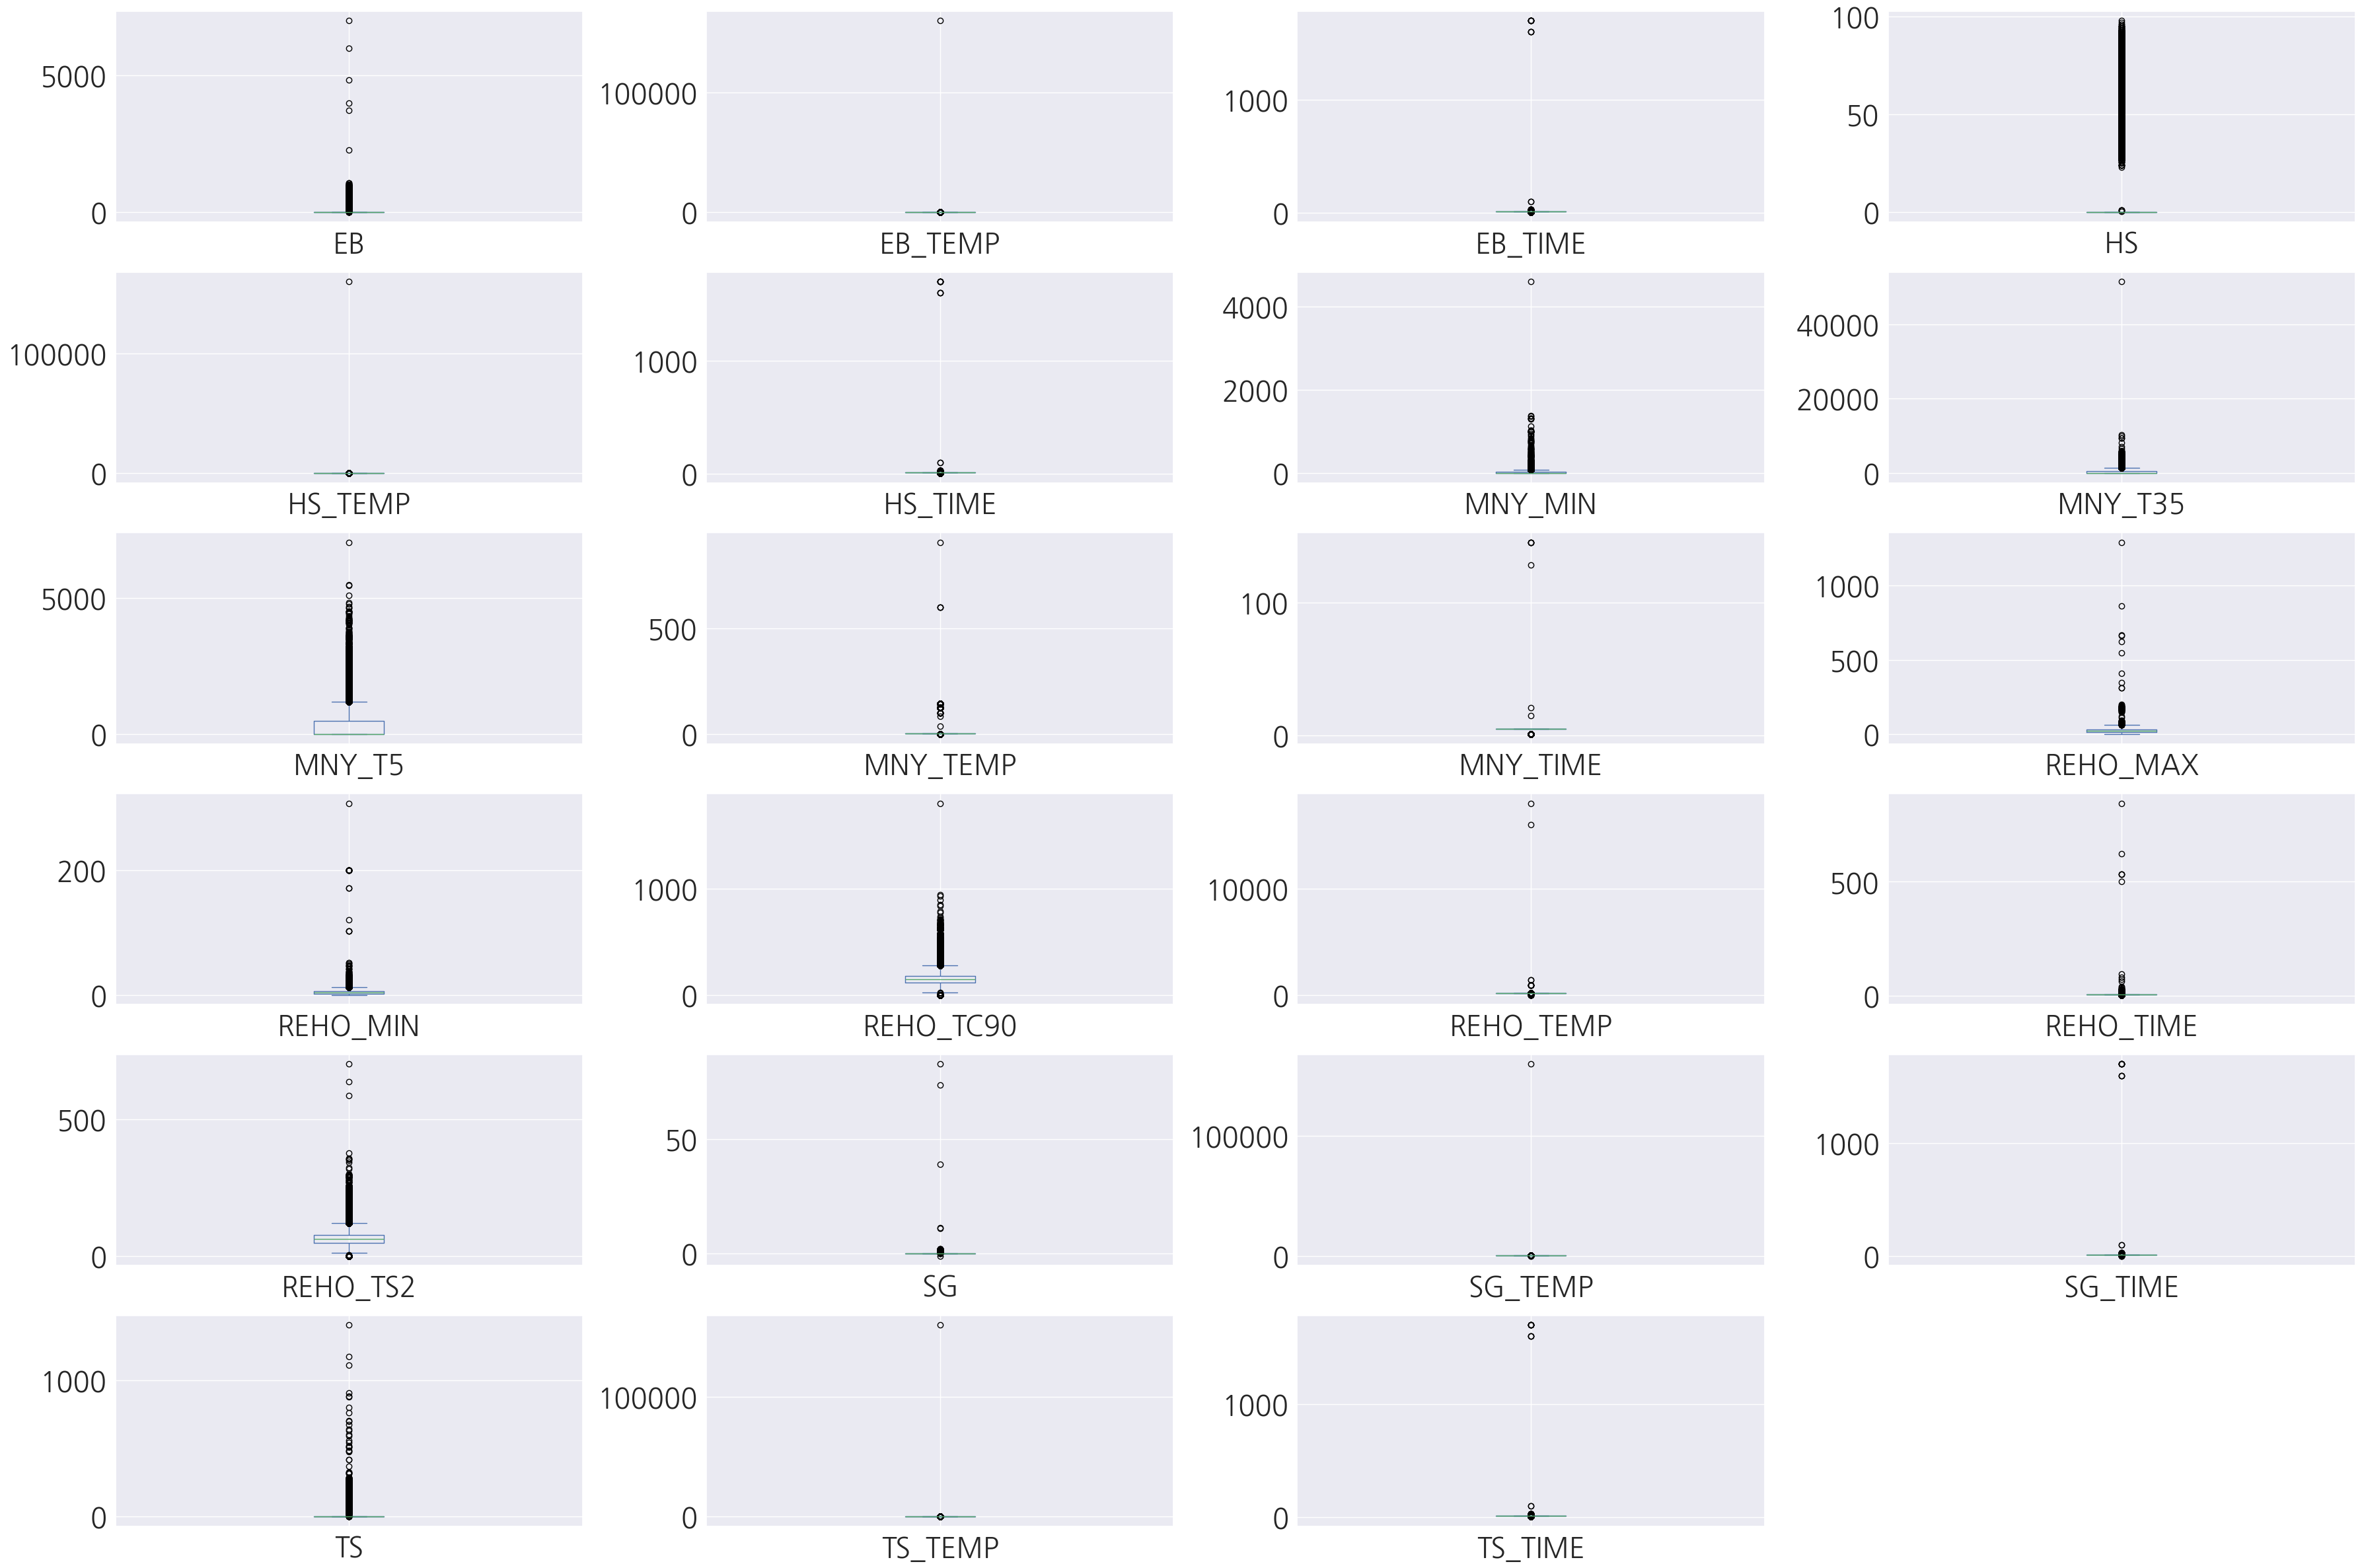

In [218]:
# plt.rcParams['font.size'] = 50  # 기본 폰트 크기
plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
plt.rcParams['xtick.labelsize'] = 30  # x축 틱 레이블 폰트 크기
plt.rcParams['ytick.labelsize'] = 30  # y축 틱 레이블 폰트 크기

numeric_columns = fin_lab_df.select_dtypes(include=['number']).columns

last_df_numer = fin_lab_df[numeric_columns]
last_df_numer.plot(kind='box', subplots=True, figsize=(36,24), layout=(-1,4))

plt.tight_layout()
plt.show()

In [219]:
# # plt.rcParams['font.size'] = 50  # 기본 폰트 크기
# plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
# plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
# plt.rcParams['xtick.labelsize'] = 25  # x축 틱 레이블 폰트 크기
# plt.rcParams['ytick.labelsize'] = 25  # y축 틱 레이블 폰트 크기

# # 히스토그램 생성
# fig, axes = plt.subplots(len(last_df_numer.columns) // 3 + 1, 3, figsize=(36,24))
# axes = axes.flatten()

# # 히스토그램과 x축 설정
# for ax, col in zip(axes, last_df_numer.columns):
#     last_df_numer[col].hist(bins=50, ax=ax)
#     ax.set_title(col)  # 축 제목 설정
#     data_min = last_df_numer[col].min()
#     x_min, x_max = ax.get_xlim()
#     ax.set_xlim(left=max(0, data_min), right=x_max)
#     ax.set_xticks(np.linspace(data_min, x_max, num=7))
    
#     # X축 레이블 위치를 더 아래로 조정
#     ax.tick_params(axis='x', which='major', pad=15)  # x축 눈금 레이블의 패딩 조정

# # 사용하지 않는 서브플롯 숨기기
# for i in range(len(last_df_numer.columns), len(axes)):
#     axes[i].set_visible(False)

# plt.tight_layout()
# plt.show()

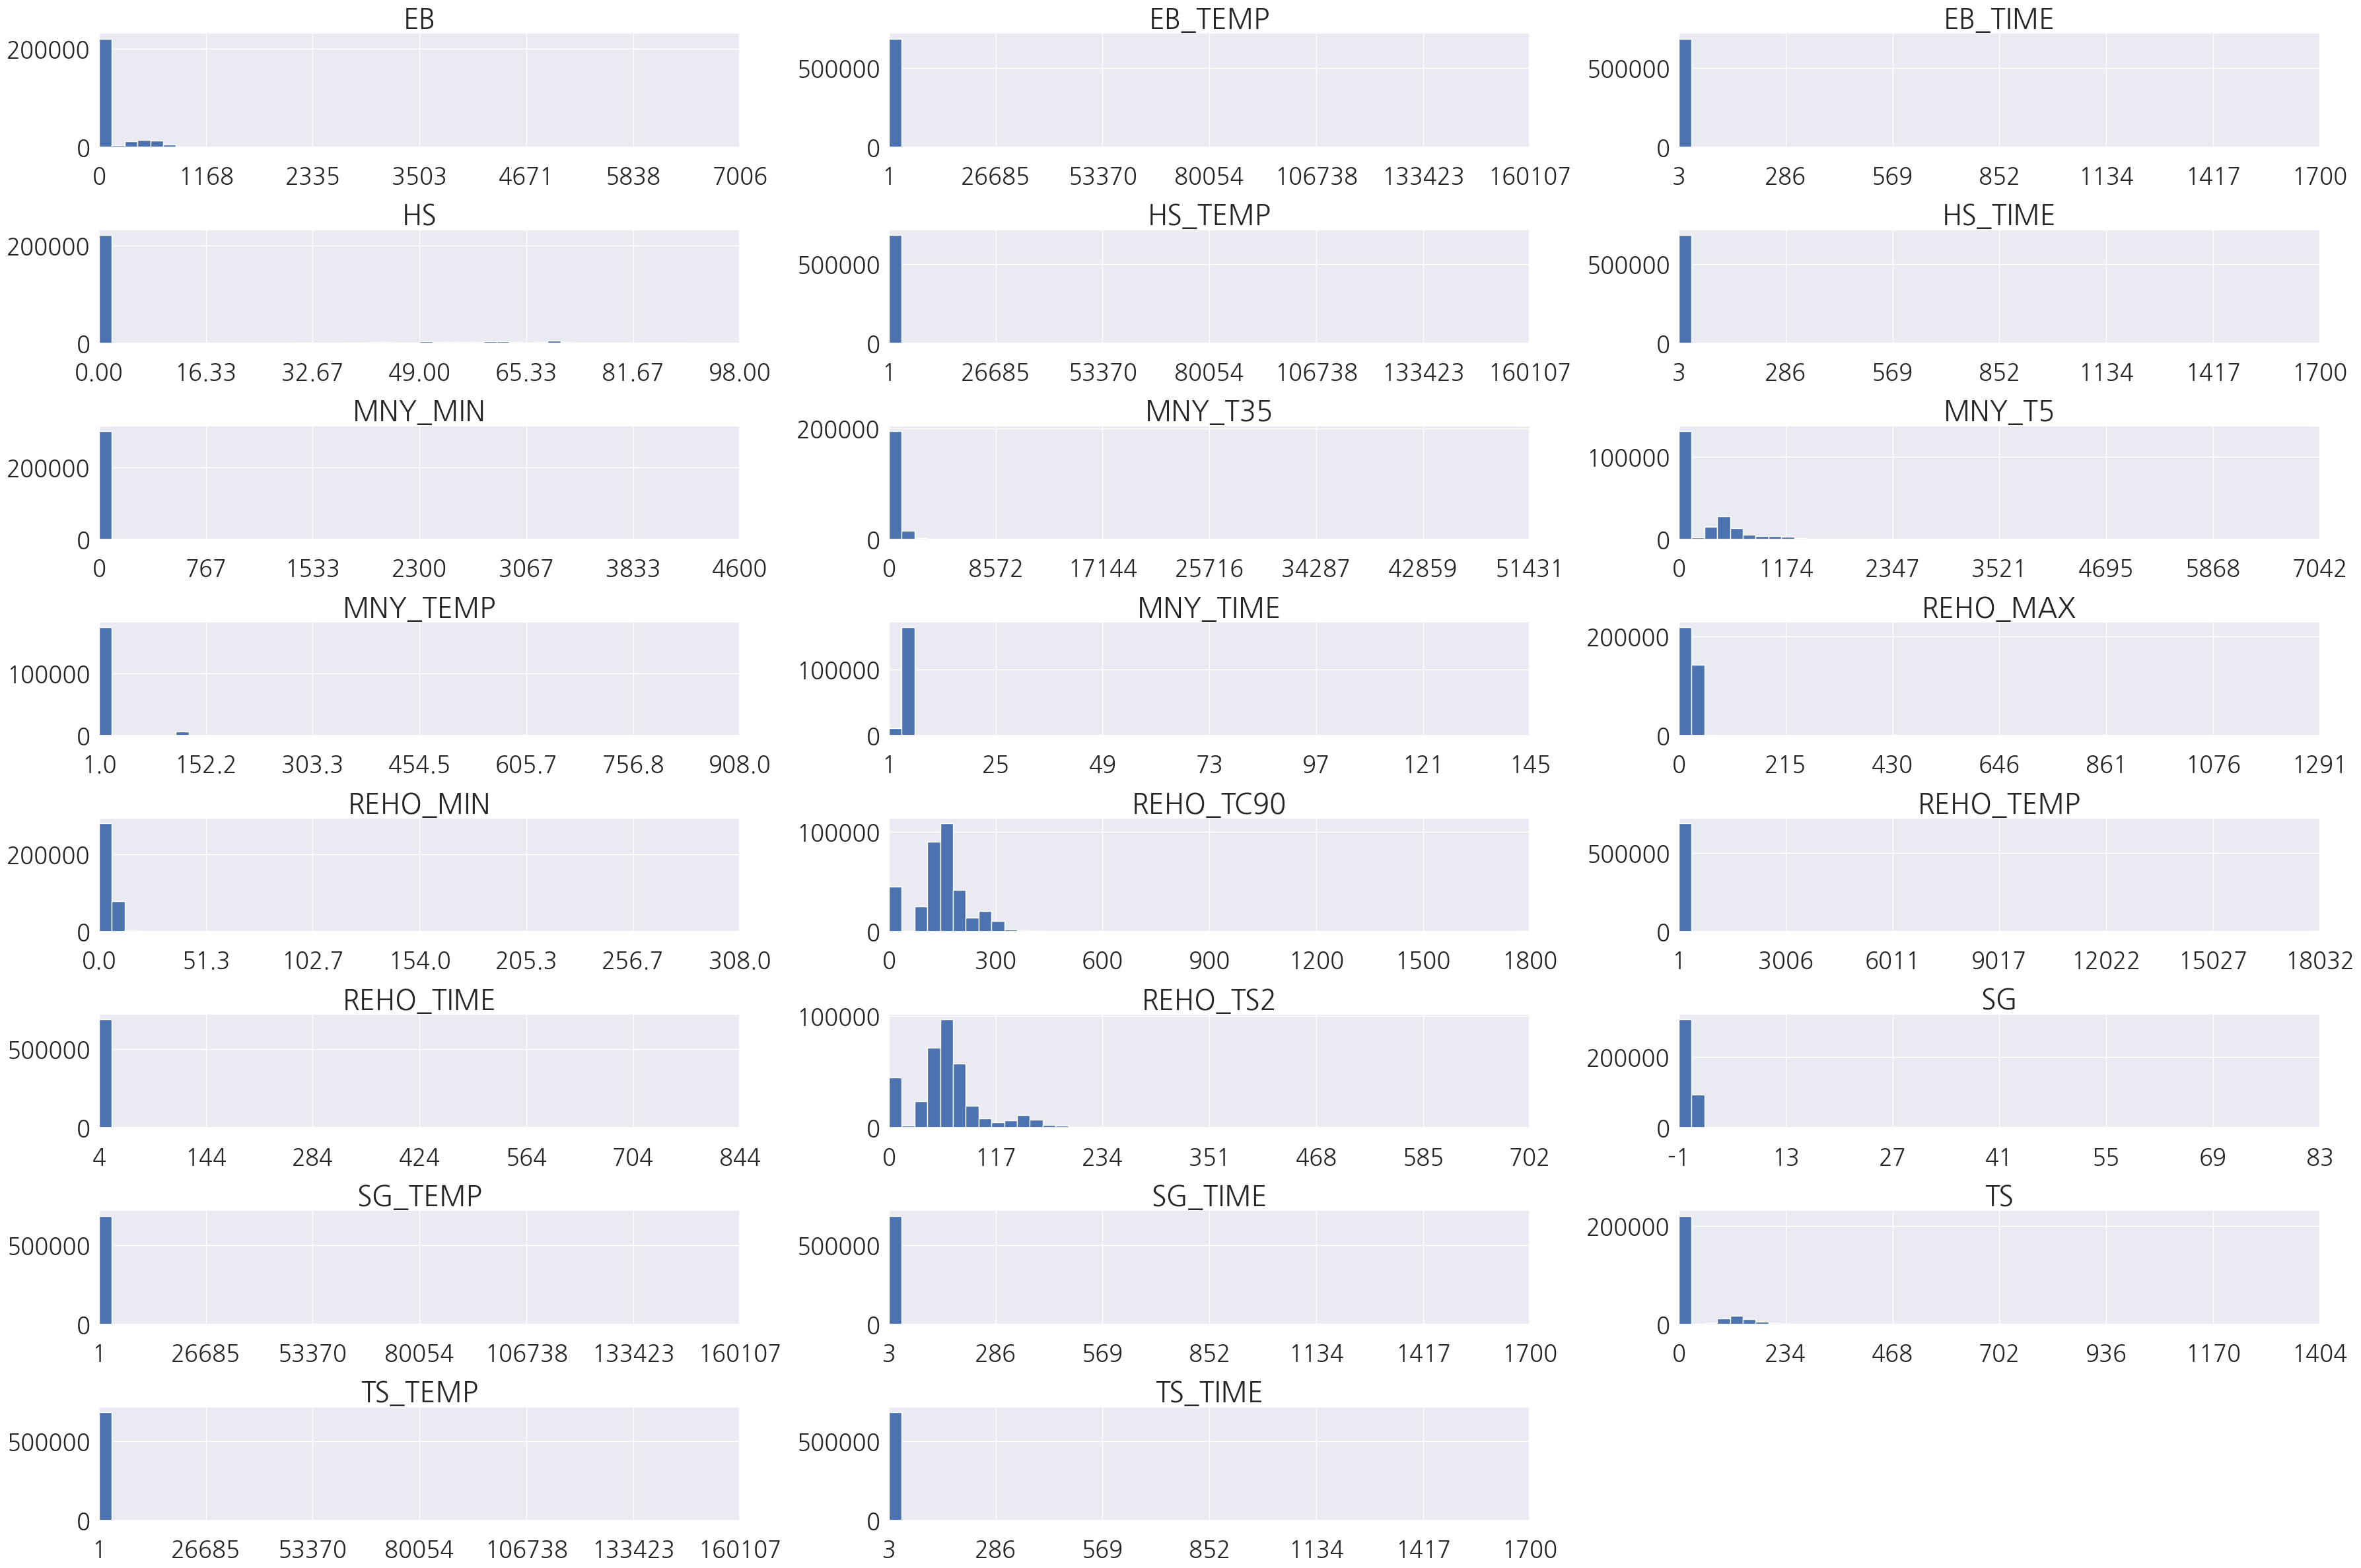

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
plt.rcParams['xtick.labelsize'] = 25  # x축 틱 레이블 폰트 크기
plt.rcParams['ytick.labelsize'] = 25  # y축 틱 레이블 폰트 크기

# 히스토그램 생성
fig, axes = plt.subplots(len(last_df_numer.columns) // 3 + 1, 3, figsize=(36, 24))
axes = axes.flatten()

# 히스토그램과 x축 설정
for ax, col in zip(axes, last_df_numer.columns):
    last_df_numer[col].hist(bins=50, ax=ax)
    ax.set_title(col)  # 축 제목 설정
    data_min = last_df_numer[col].min()
    data_max = last_df_numer[col].max()  # 데이터의 최대값 계산
    x_min, x_max = ax.get_xlim()

    # X축의 범위를 데이터의 최소값과 최대값으로 설정
    ax.set_xlim(left=data_min, right=data_max)
    ax.set_xticks(np.linspace(data_min, data_max, num=7))
    
    # X축 레이블 위치를 더 아래로 조정
    ax.tick_params(axis='x', which='major', pad=15)  # x축 눈금 레이블의 패딩 조정

# 사용하지 않는 서브플롯 숨기기
for i in range(len(last_df_numer.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [221]:
last_df_numer.columns

Index(['EB', 'EB_TEMP', 'EB_TIME', 'HS', 'HS_TEMP', 'HS_TIME', 'MNY_MIN',
       'MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN',
       'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2', 'SG', 'SG_TEMP',
       'SG_TIME', 'TS', 'TS_TEMP', 'TS_TIME'],
      dtype='object')

In [222]:
last_df_numer['REHO_TIME'].value_counts()

REHO_TIME
5.0      553226
8.0       74681
10.0      31336
6.0       13078
4.0        6623
12.0       6127
15.0        788
20.0         63
16.0         23
30.0         14
24.0         14
7.0           6
532.0         2
534.0         1
65.0          1
622.0         1
500.0         1
844.0         1
39.0          1
40.0          1
35.0          1
82.0          1
73.0          1
97.0          1
Name: count, dtype: int64

In [223]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # last_df_numer 데이터프레임의 각 컬럼에 대해 히스토그램 그리기
# for i in last_df_numer.columns:
#     sns.histplot(last_df_numer[i], bins=50)
#     plt.title(i, fontsize=36)  # 제목 설정과 폰트 크기 조정

#     # x축의 최소값과 최대값 계산
#     data_min = last_df_numer[i].min()  # 데이터의 최소값 계산
#     data_max = last_df_numer[i].max()  # 데이터의 최대값 계산

#     # x축 범위 설정
#     plt.xlim(data_min, data_max)  # x축의 시작을 데이터의 최소값, 끝을 최대값으로 설정

#     # 눈금 재설정
#     plt.xticks(np.linspace(data_min, data_max, num=10))  # x축에 10개의 눈금 설정

#     plt.show()

In [224]:
# 이상치 비율
def calculate_outlier_percentages(df):
    # 숫자형 컬럼 추출
    numeric_cols = df.select_dtypes(include=[int, float])
    
    # 이상치 비율 저장을 위한 딕셔너리
    outlier_percentages = {}
    
    # 각 숫자형 컬럼에 대해 이상치 비율 계산
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 계산
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percentage = len(outliers) / len(df) * 100
        
        # 딕셔너리에 저장
        outlier_percentages[col] = outlier_percentage
        
    return outlier_percentages

# 이상치 비율 계산
calculate_outlier_percentages(fin_lab_df)

{'EB': 5.836755132699048,
 'EB_TEMP': 22.169725175999293,
 'EB_TIME': 9.033903796871778,
 'HS': 6.041768535155675,
 'HS_TEMP': 22.169725175999293,
 'HS_TIME': 9.033903796871778,
 'MNY_MIN': 0.527614951839524,
 'MNY_T35': 0.7089457715985743,
 'MNY_T5': 0.9086571033020118,
 'MNY_TEMP': 2.0958496568381983,
 'MNY_TIME': 1.2892279595864384,
 'REHO_MAX': 0.02544993961530531,
 'REHO_MIN': 0.41697840878965503,
 'REHO_TC90': 8.048543403340304,
 'REHO_TEMP': 11.918701581784442,
 'REHO_TIME': 15.642993902618635,
 'REHO_TS2': 9.345429909570239,
 'SG': 11.079089222068397,
 'SG_TEMP': 22.169725175999293,
 'SG_TIME': 9.033903796871778,
 'TS': 5.8359303661374415,
 'TS_TEMP': 22.169725175999293,
 'TS_TIME': 9.033903796871778}

In [226]:
# IQR 기반 이상치 제거 함수 (숫자형 컬럼에만 적용)
def remove_outliers(df):
    # 숫자형 컬럼 선택
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # 결과를 저장할 데이터프레임은 원본을 복사하여 생성
    clean_df = df.copy()
    
    for column in numeric_cols:
        # Q1, Q3 계산
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # 하한, 상한 계산
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치가 아닌 데이터만 필터링
        clean_df[column] = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return clean_df

# 이상치 제거 실행
clean_df = remove_outliers(fin_lab_df)

In [227]:
# # plt.rcParams['font.size'] = 50  # 기본 폰트 크기
# plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
# plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
# plt.rcParams['xtick.labelsize'] = 30  # x축 틱 레이블 폰트 크기
# plt.rcParams['ytick.labelsize'] = 30  # y축 틱 레이블 폰트 크기

# numeric_columns = clean_df.select_dtypes(include=['number']).columns

# last_df_numer = clean_df[numeric_columns]
# last_df_numer.plot(kind='box', subplots=True, figsize=(36,24), layout=(-1,4))

# plt.tight_layout()
# plt.show()

In [228]:
# 이상치 비율
def calculate_outlier_percentages(df):
    # 숫자형 컬럼 추출
    numeric_cols = df.select_dtypes(include=[int, float])
    
    # 이상치 비율 저장을 위한 딕셔너리
    outlier_percentages = {}
    
    # 각 숫자형 컬럼에 대해 이상치 비율 계산
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 계산
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percentage = len(outliers) / len(df) * 100
        
        # 딕셔너리에 저장
        outlier_percentages[col] = outlier_percentage
        
    return outlier_percentages

# 이상치 비율 계산
calculate_outlier_percentages(clean_df)

{'EB': 0.0,
 'EB_TEMP': 0.0,
 'EB_TIME': 0.0,
 'HS': 0.0,
 'HS_TEMP': 0.0,
 'HS_TIME': 0.0,
 'MNY_MIN': 0.22916728033226308,
 'MNY_T35': 0.27005213702907305,
 'MNY_T5': 0.20654511178532503,
 'MNY_TEMP': 0.0,
 'MNY_TIME': 0.0,
 'REHO_MAX': 0.0,
 'REHO_MIN': 0.0,
 'REHO_TC90': 1.5914459925181892,
 'REHO_TEMP': 0.0,
 'REHO_TIME': 0.0,
 'REHO_TS2': 0.6257621726707708,
 'SG': 0.0,
 'SG_TEMP': 0.0,
 'SG_TIME': 0.0,
 'TS': 0.0,
 'TS_TEMP': 0.0,
 'TS_TIME': 0.0}

In [212]:
import pandas as pd
import numpy as np

# last_df_numer 데이터프레임을 가정
columns = ['EB', 'EB_TEMP', 'EB_TIME', 'HS', 'HS_TEMP', 'HS_TIME', 'MNY_MIN',
           'MNY_T35', 'MNY_T5', 'MNY_TEMP', 'MNY_TIME', 'REHO_MAX', 'REHO_MIN',
           'REHO_TC90', 'REHO_TEMP', 'REHO_TIME', 'REHO_TS2', 'SG', 'SG_TEMP',
           'SG_TIME', 'TS', 'TS_TEMP', 'TS_TIME']

# '_TIME'과 '_TEMP'를 제외한 모든 컬럼 선택
cols_to_update = [col for col in columns if not col.endswith(('_TIME', '_TEMP'))]
last_df_numer_zero = last_df_numer.copy()
# 선택한 컬럼에서 0을 NaN으로 변환
last_df_numer_zero[cols_to_update] = last_df_numer_zero[cols_to_update].replace(0, np.nan)

In [213]:
cols_to_update

['EB',
 'HS',
 'MNY_MIN',
 'MNY_T35',
 'MNY_T5',
 'REHO_MAX',
 'REHO_MIN',
 'REHO_TC90',
 'REHO_TS2',
 'SG',
 'TS']

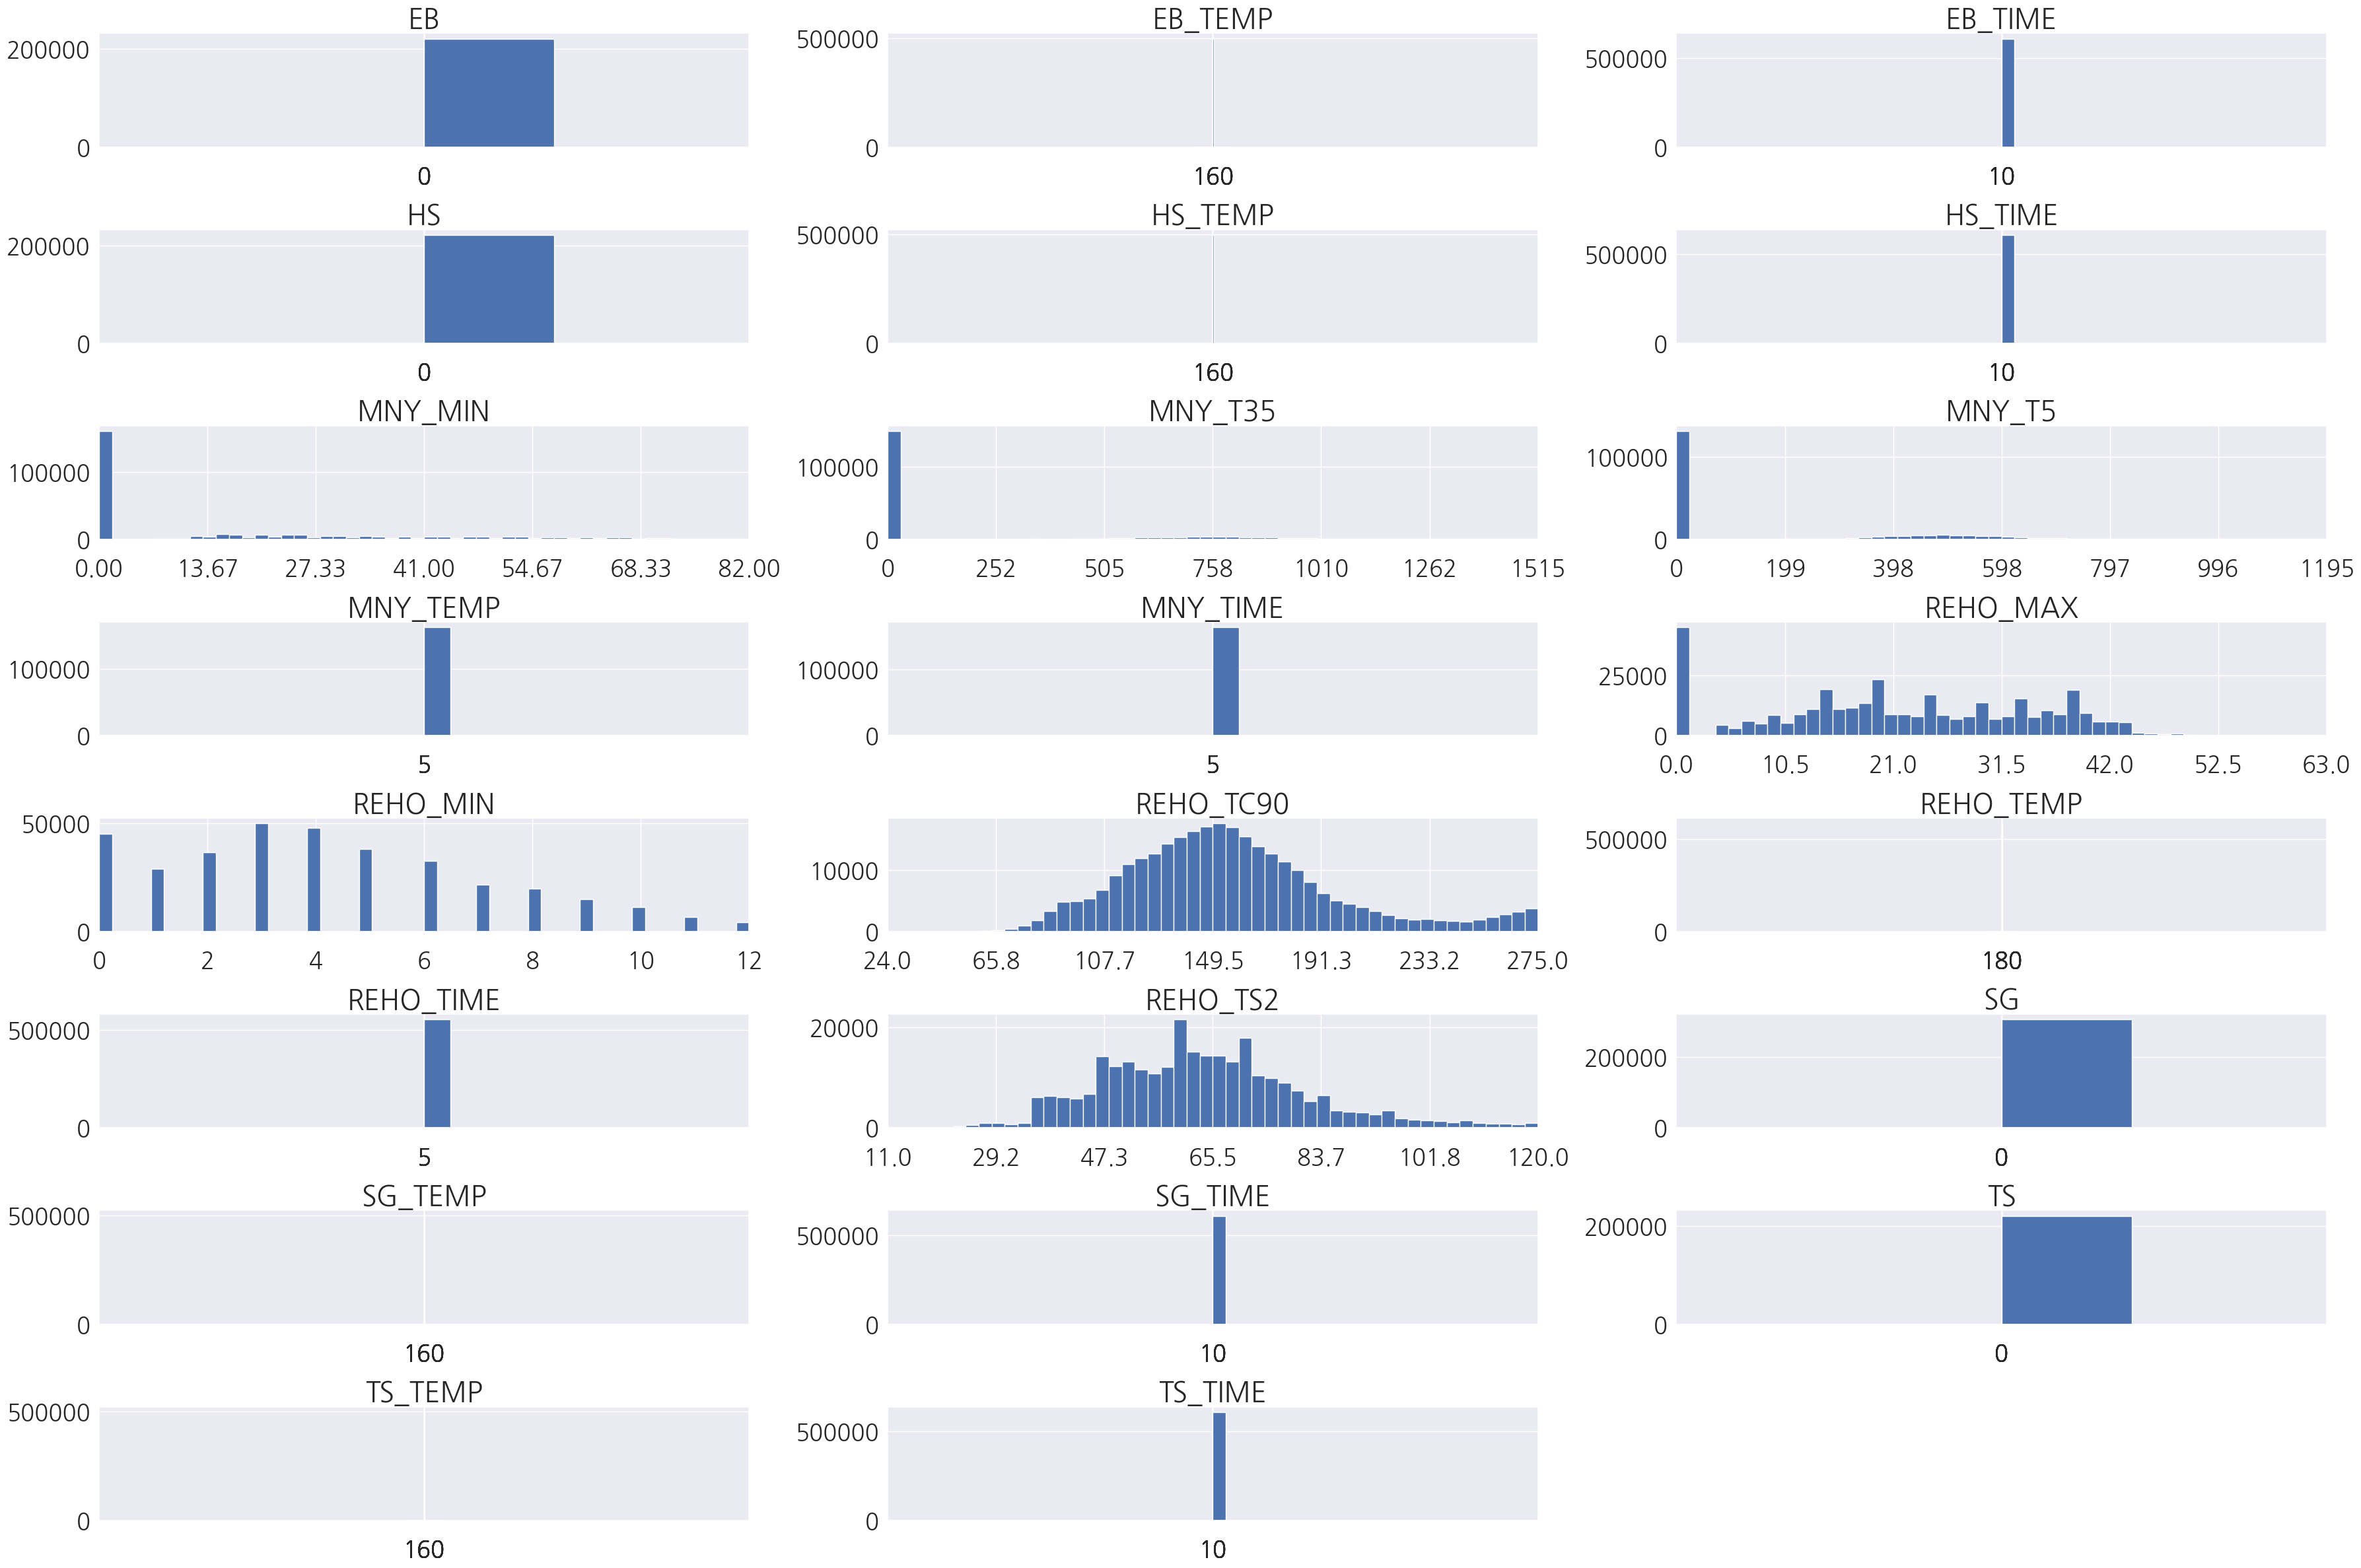

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
plt.rcParams['xtick.labelsize'] = 25  # x축 틱 레이블 폰트 크기
plt.rcParams['ytick.labelsize'] = 25  # y축 틱 레이블 폰트 크기

# 히스토그램 생성
fig, axes = plt.subplots(len(clean_df.columns) // 3 + 1, 3, figsize=(36, 24))
axes = axes.flatten()

# 히스토그램과 x축 설정
for ax, col in zip(axes, clean_df.columns):
    clean_df[col].hist(bins=50, ax=ax)
    ax.set_title(col)  # 축 제목 설정
    data_min = clean_df[col].min()
    data_max = clean_df[col].max()  # 데이터의 최대값 계산
    x_min, x_max = ax.get_xlim()

    # X축의 범위를 데이터의 최소값과 최대값으로 설정
    ax.set_xlim(left=data_min, right=data_max)
    ax.set_xticks(np.linspace(data_min, data_max, num=7))
    
    # X축 레이블 위치를 더 아래로 조정
    ax.tick_params(axis='x', which='major', pad=15)  # x축 눈금 레이블의 패딩 조정

# 사용하지 않는 서브플롯 숨기기
for i in range(len(clean_df.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

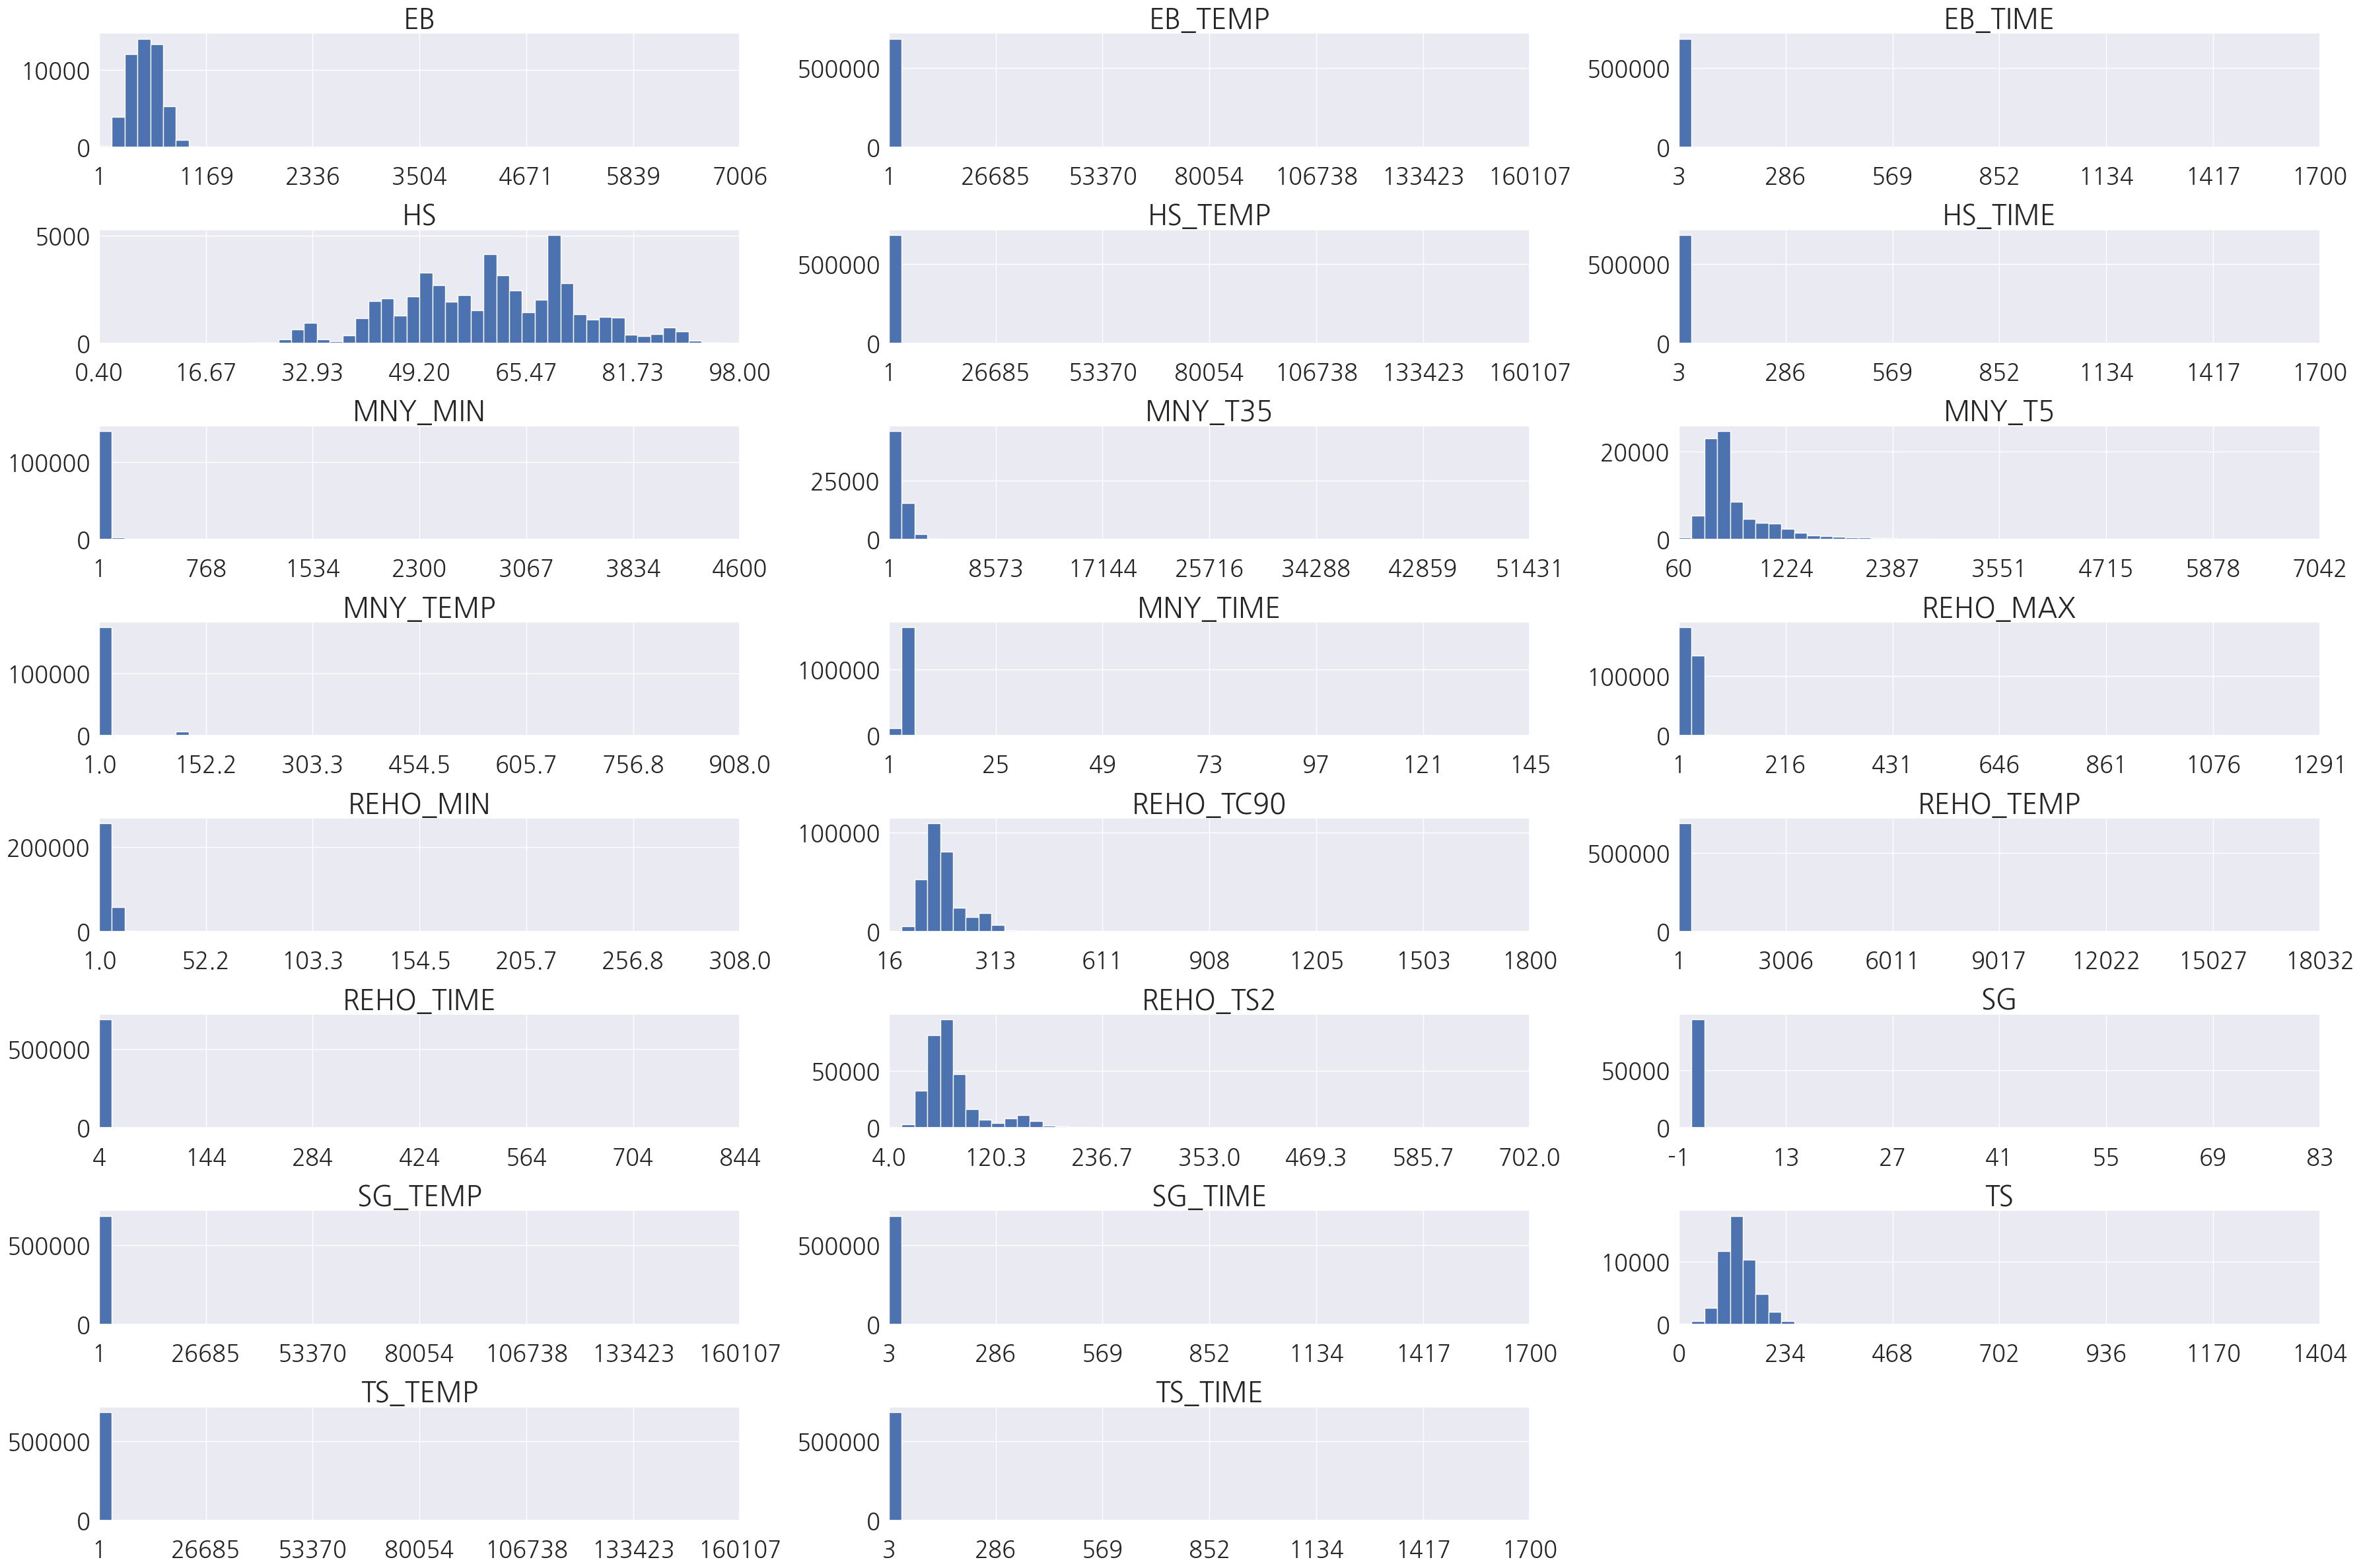

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
plt.rcParams['xtick.labelsize'] = 25  # x축 틱 레이블 폰트 크기
plt.rcParams['ytick.labelsize'] = 25  # y축 틱 레이블 폰트 크기

# 히스토그램 생성
fig, axes = plt.subplots(len(last_df_numer_zero.columns) // 3 + 1, 3, figsize=(36, 24))
axes = axes.flatten()

# 히스토그램과 x축 설정
for ax, col in zip(axes, last_df_numer_zero.columns):
    last_df_numer_zero[col].hist(bins=50, ax=ax)
    ax.set_title(col)  # 축 제목 설정
    data_min = last_df_numer_zero[col].min()
    data_max = last_df_numer_zero[col].max()  # 데이터의 최대값 계산
    x_min, x_max = ax.get_xlim()

    # X축의 범위를 데이터의 최소값과 최대값으로 설정
    ax.set_xlim(left=data_min, right=data_max)
    ax.set_xticks(np.linspace(data_min, data_max, num=7))
    
    # X축 레이블 위치를 더 아래로 조정
    ax.tick_params(axis='x', which='major', pad=15)  # x축 눈금 레이블의 패딩 조정

# 사용하지 않는 서브플롯 숨기기
for i in range(len(last_df_numer_zero.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [238]:
last_df_numer_zero['MNY_MIN'].value_counts().sort_index()

MNY_MIN
1.0        5
2.0        6
3.0        4
4.0       20
5.0       55
          ..
1315.0     1
1326.0     1
1369.0     1
1386.0     1
4600.0     1
Name: count, Length: 297, dtype: int64

In [106]:
# # 'EB' 컬럼 값이 0이 아니고, null이 아닌 행을 필터링
# filtered_df = total_df[(total_df['EB'] != 0) & (total_df['EB'].notnull())]

# # 필터링된 데이터프레임의 길이(행의 수)를 계산
# length = len(filtered_df)

# length  # 이 값이 조건을 만족하는 행의 개수

In [244]:
# IQR 기반 이상치 제거 함수 (숫자형 컬럼에만 적용)
def remove_outliers(df):
    # 숫자형 컬럼 선택
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # 결과를 저장할 데이터프레임은 원본을 복사하여 생성
    clean_df = df.copy()
    
    for column in numeric_cols:
        # Q1, Q3 계산
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # 하한, 상한 계산
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치가 아닌 데이터만 필터링
        clean_df[column] = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return clean_df

# 이상치 제거 실행
last_df_numer_zero_clean_15 = remove_outliers(last_df_numer_zero)

In [247]:
# IQR 기반 이상치 제거 함수 (숫자형 컬럼에만 적용)
def remove_outliers(df):
    # 숫자형 컬럼 선택
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # 결과를 저장할 데이터프레임은 원본을 복사하여 생성
    clean_df = df.copy()
    
    for column in numeric_cols:
        # Q1, Q3 계산
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # 하한, 상한 계산
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        # 이상치가 아닌 데이터만 필터링
        clean_df[column] = df[column][(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return clean_df

# 이상치 제거 실행
last_df_numer_zero_clean_3 = remove_outliers(last_df_numer_zero)

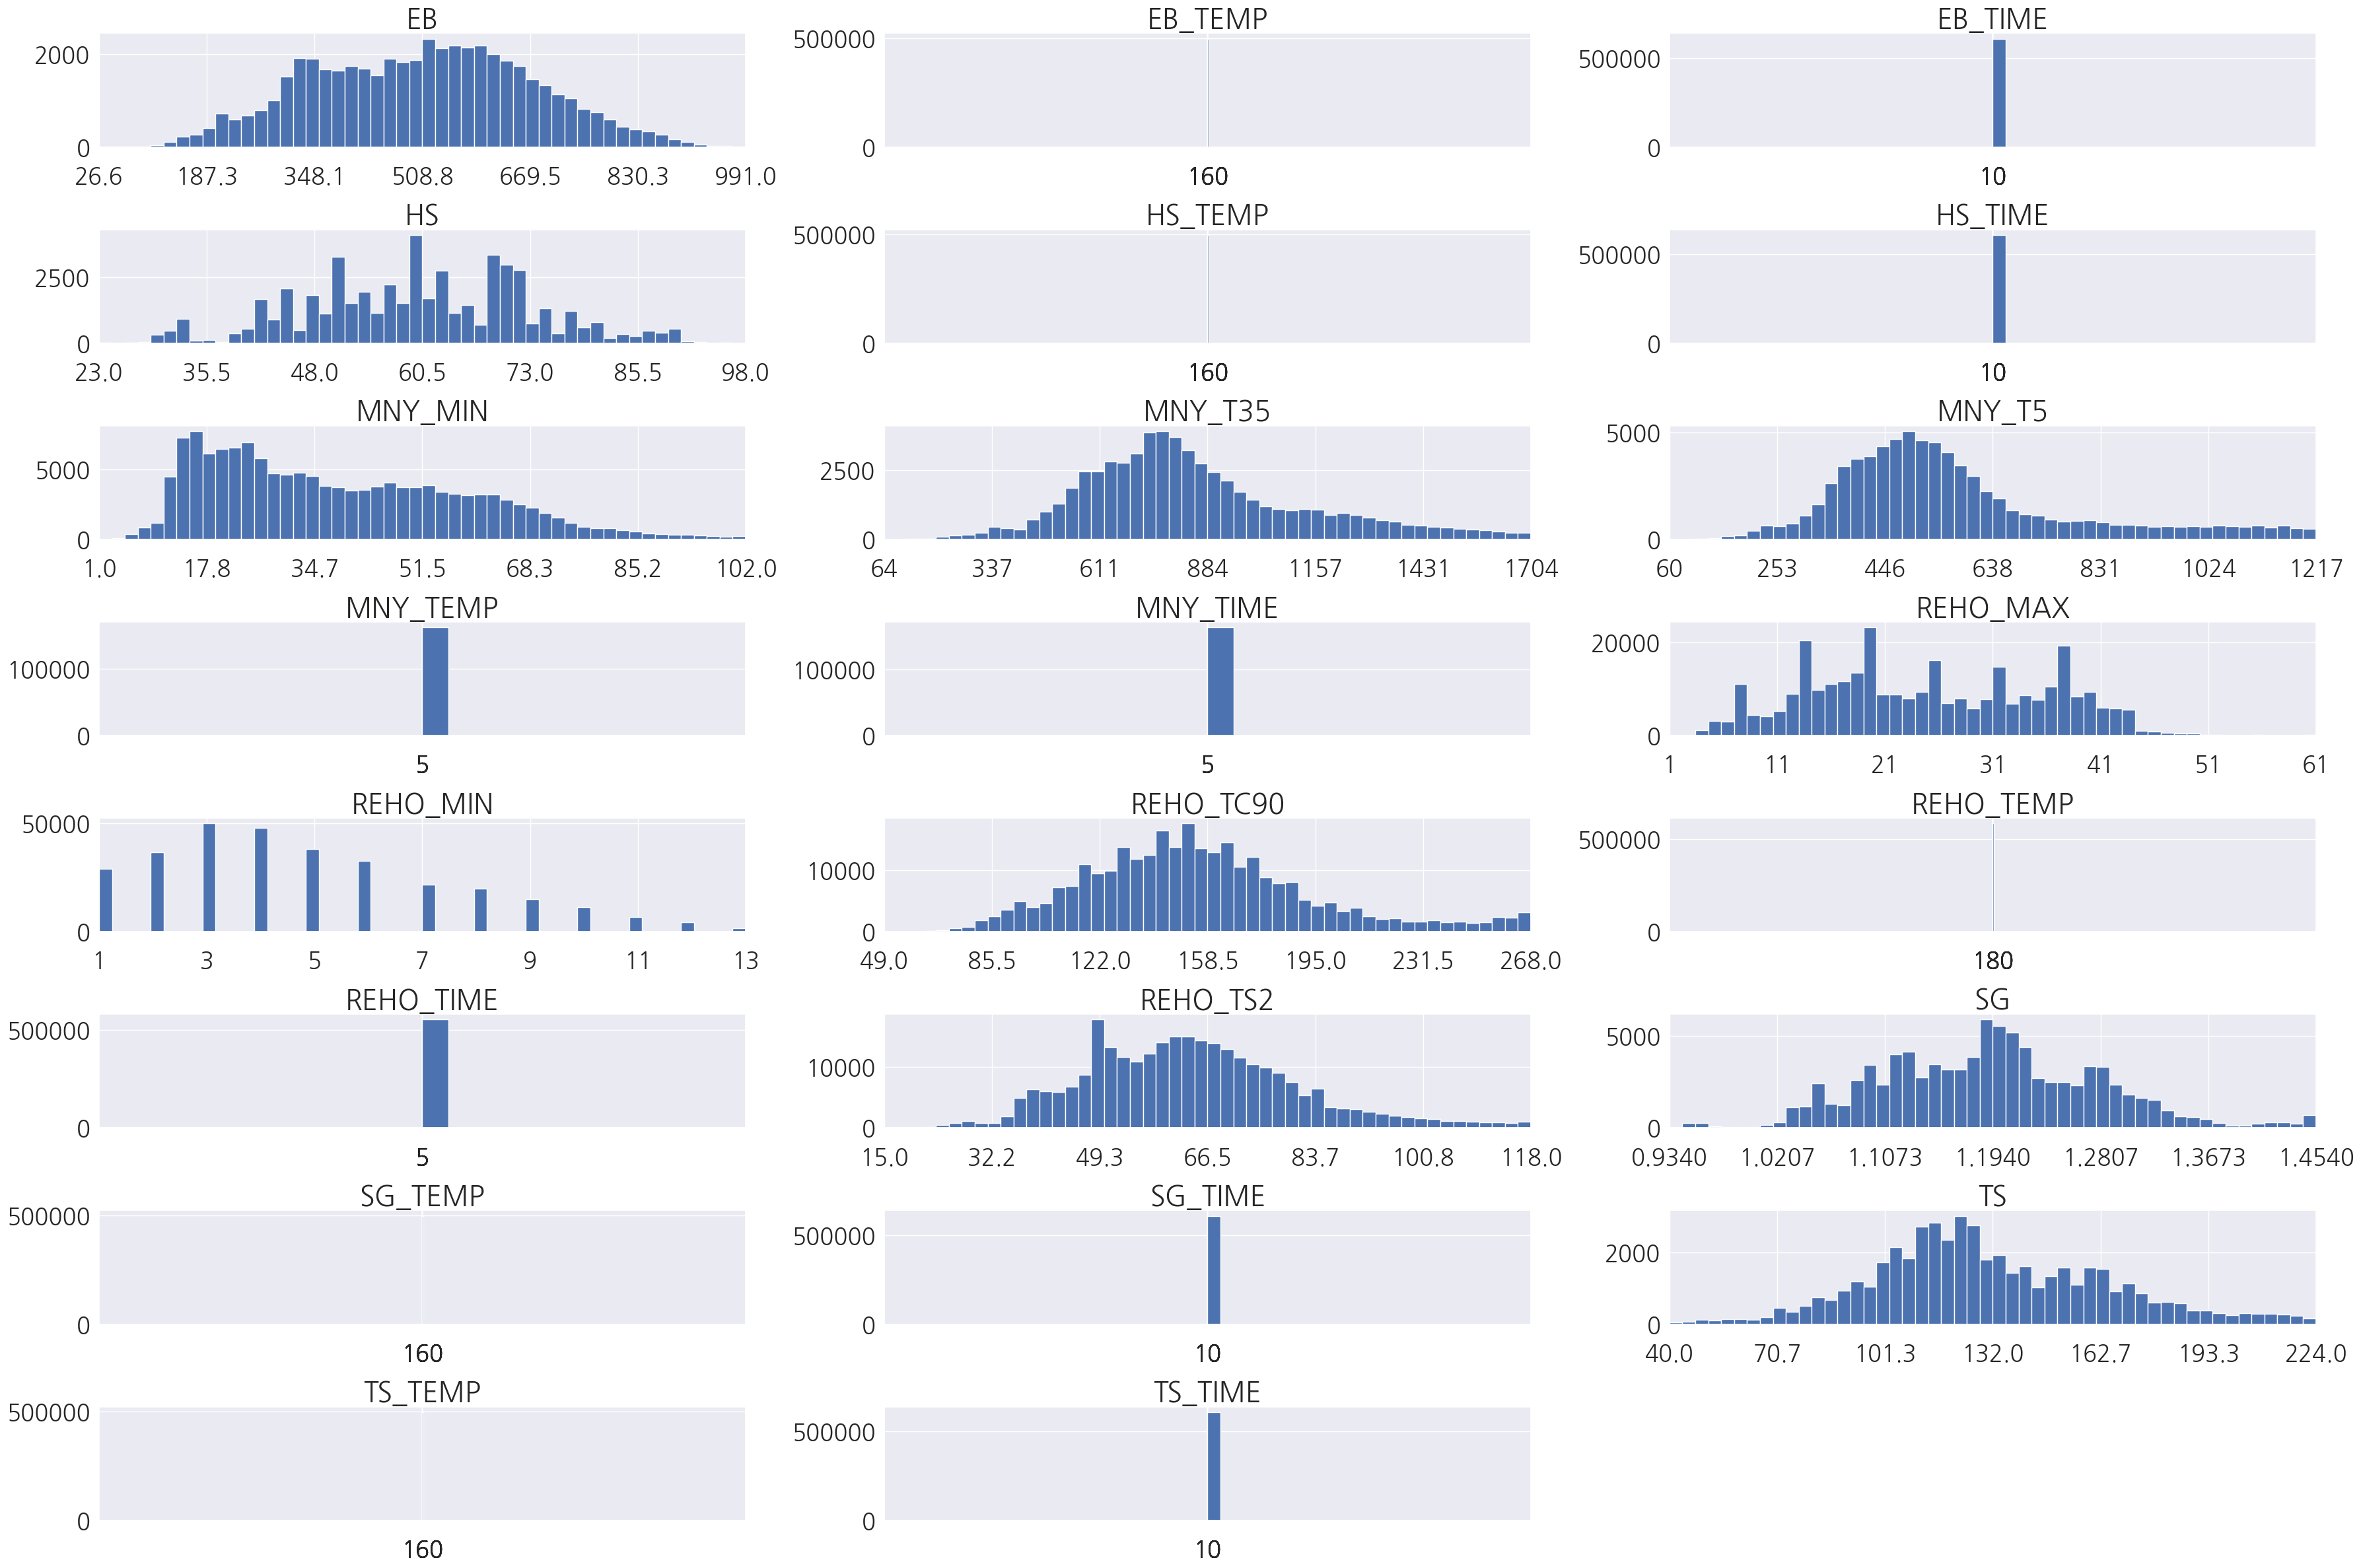

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
plt.rcParams['xtick.labelsize'] = 25  # x축 틱 레이블 폰트 크기
plt.rcParams['ytick.labelsize'] = 25  # y축 틱 레이블 폰트 크기

# 히스토그램 생성
fig, axes = plt.subplots(len(last_df_numer_zero_clean.columns) // 3 + 1, 3, figsize=(36, 24))
axes = axes.flatten()

# 히스토그램과 x축 설정
for ax, col in zip(axes, last_df_numer_zero_clean.columns):
    last_df_numer_zero_clean[col].hist(bins=50, ax=ax)
    ax.set_title(col)  # 축 제목 설정
    data_min = last_df_numer_zero_clean[col].min()
    data_max = last_df_numer_zero_clean[col].max()  # 데이터의 최대값 계산
    x_min, x_max = ax.get_xlim()

    # X축의 범위를 데이터의 최소값과 최대값으로 설정
    ax.set_xlim(left=data_min, right=data_max)
    ax.set_xticks(np.linspace(data_min, data_max, num=7))
    
    # X축 레이블 위치를 더 아래로 조정
    ax.tick_params(axis='x', which='major', pad=15)  # x축 눈금 레이블의 패딩 조정

# 사용하지 않는 서브플롯 숨기기
for i in range(len(last_df_numer_zero_clean.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

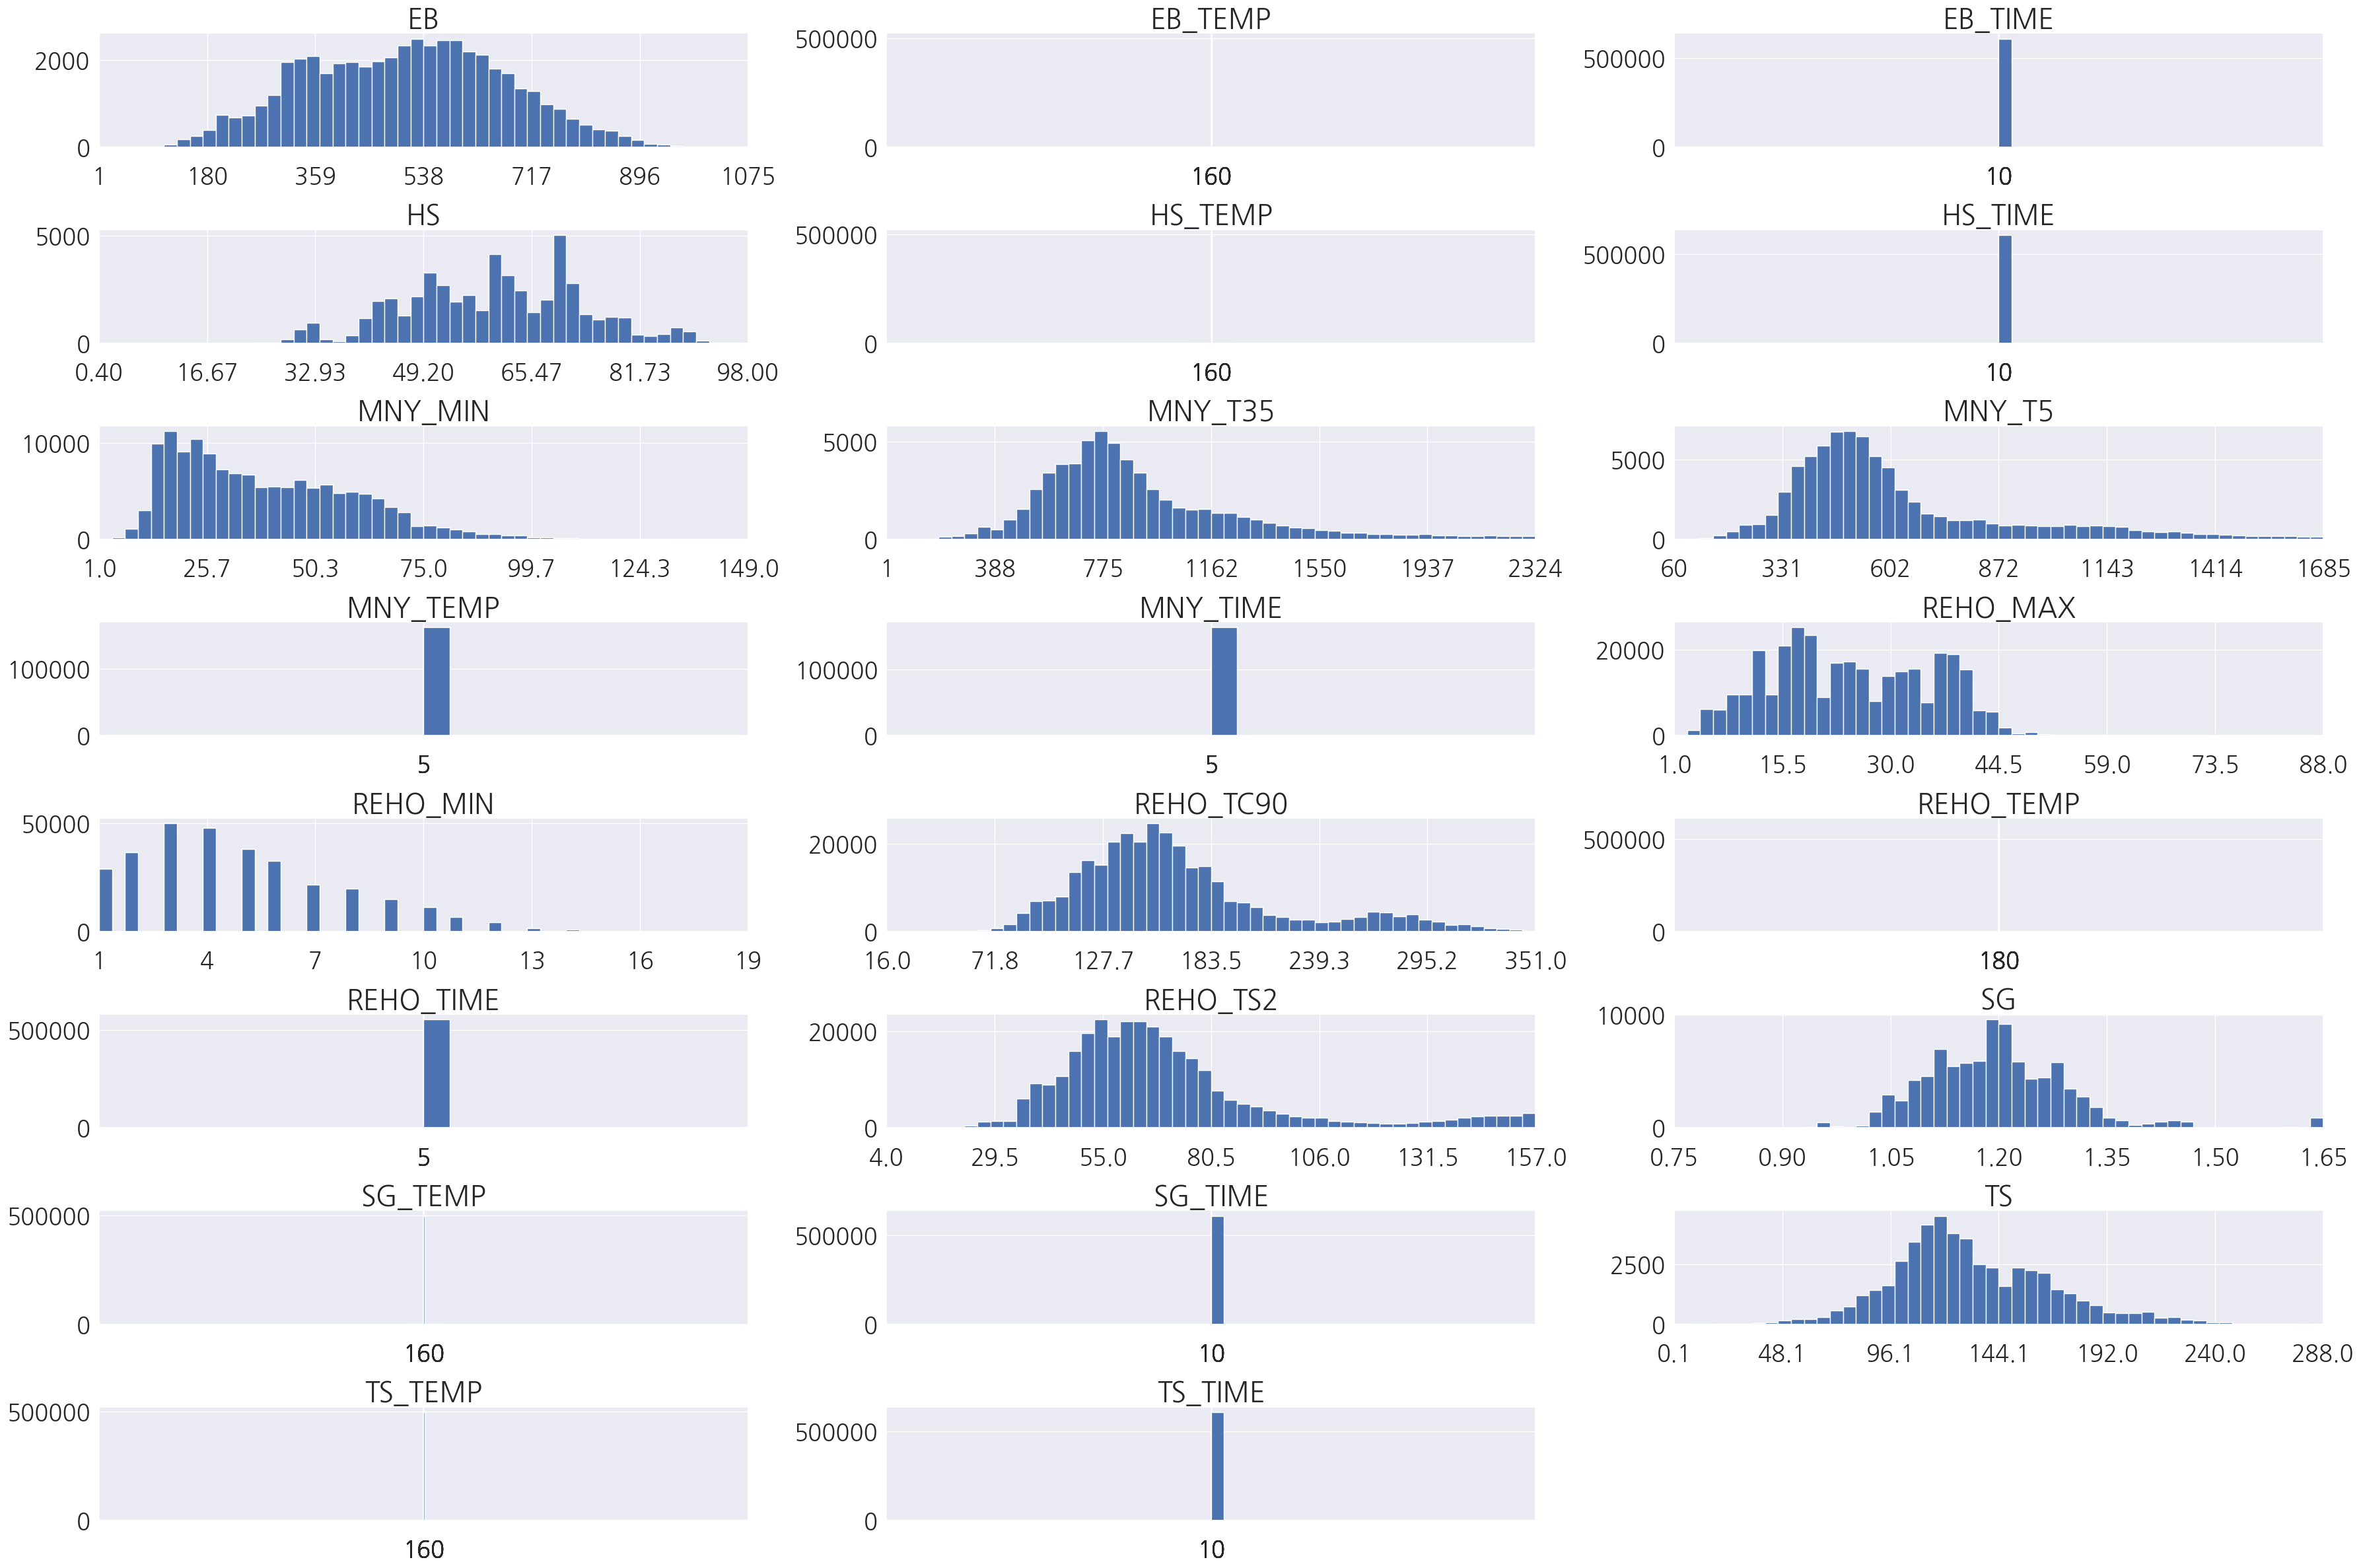

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['axes.labelsize'] = 50  # x, y축 레이블 폰트 크기
plt.rcParams['axes.titlesize'] = 30  # 타이틀 폰트 크기
plt.rcParams['xtick.labelsize'] = 25  # x축 틱 레이블 폰트 크기
plt.rcParams['ytick.labelsize'] = 25  # y축 틱 레이블 폰트 크기

# 히스토그램 생성
fig, axes = plt.subplots(len(last_df_numer_zero_clean_3.columns) // 3 + 1, 3, figsize=(36, 24))
axes = axes.flatten()

# 히스토그램과 x축 설정
for ax, col in zip(axes, last_df_numer_zero_clean_3.columns):
    last_df_numer_zero_clean_3[col].hist(bins=50, ax=ax)
    ax.set_title(col)  # 축 제목 설정
    data_min = last_df_numer_zero_clean_3[col].min()
    data_max = last_df_numer_zero_clean_3[col].max()  # 데이터의 최대값 계산
    x_min, x_max = ax.get_xlim()

    # X축의 범위를 데이터의 최소값과 최대값으로 설정
    ax.set_xlim(left=data_min, right=data_max)
    ax.set_xticks(np.linspace(data_min, data_max, num=7))
    
    # X축 레이블 위치를 더 아래로 조정
    ax.tick_params(axis='x', which='major', pad=15)  # x축 눈금 레이블의 패딩 조정

# 사용하지 않는 서브플롯 숨기기
for i in range(len(last_df_numer_zero_clean_3.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [242]:
last_df_numer_zero_clean['REHO_TEMP'].value_counts()

REHO_TEMP
180.0    584856
Name: count, dtype: int64

### 2) PHR 데이터 조건부 처리 및 수치 상대적 조정
- 최대 100으로 조정
- Fn과 Cn에 따른 데이터 필터링 등

#### phr : float64, 값의 범위 체크해야함. [2분정도 소요]
- phr 이 일반적으로 100을 넘기지 않는데 (100이하 97.3%), 넘는 부분들이 발생
- 황다혜 수석님과 논의 후, 100을 넘기는 lab_cd와 test_no 리스트를 화인테크에 검토받기로 하여 자료 넘김
    - 1-1) 각 검사별(lab_cd/test_no)로 최대 phr이 100이 아닌 경우	
        - mix_ds_cd == Cn인 경우, (value/최대값*100)으로 변환 후 사용
        - mix_ds_cd == *F은 Fn보다 우선됨, *F과 Cn 데이터들을 포함하여 (value/최대값*100)으로 변환 후 사용
        - mix_ds_cd == Fn인 경우, Cn 데이터들을 포함하여 (value/최대값*100)으로 변환 후 사용
	
    - 1-2) 각 검사별(lab_cd/test_no)로 최대 phr이 100인 경우, 그대로 사용	

# 데이터 체크
fin_lab_df['phr']=fin_lab_df['phr'].astype(str).str.replace(',','').astype(float)
fin_lab_df['phr'].dtype

# 최대 phr가 100이 아닌 lab_pk 리스트 생성
tmp_df=fin_lab_df.groupby(['lab_pk'])['phr'].max().reset_index()
nonePHR100_ls=tmp_df[tmp_df['phr']!=100]['lab_pk'].unique().tolist()
print(len(nonePHR100_ls))

# 구분하여 생성
PHR100_lab_tmp=fin_lab_df[~(fin_lab_df['lab_pk'].isin(nonePHR100_ls))]
nonePHR100_lab_tmp=fin_lab_df[(fin_lab_df['lab_pk'].isin(nonePHR100_ls))]
print('ori:',len(fin_lab_df),'sum:',len(PHR100_lab_tmp)+len(nonePHR100_lab_tmp))

# none PHR 100 조정
nonePHR100_lab_fin=pd.DataFrame()
for nonePHR100_pk in tqdm(nonePHR100_ls):
    tmp_df=nonePHR100_lab_tmp[nonePHR100_lab_tmp['lab_pk']==nonePHR100_pk]
    maxPhr=tmp_df['phr'].max()
    
    cn_ls=tmp_df[tmp_df['mix_ds_cd'].str.contains('C')]['mix_ds_cd'].unique().tolist()
    f_ls=tmp_df[tmp_df['mix_ds_cd'].str.contains('F')]['mix_ds_cd'].unique().tolist()
    
    for cn_val in cn_ls:
        tmp_cn_df=tmp_df[tmp_df['mix_ds_cd']==cn_val]
        maxPhr=tmp_cn_df['phr'].max()
        tmp_cn_df['phr']=tmp_cn_df['phr']/maxPhr*100
        nonePHR100_lab_fin=pd.concat([nonePHR100_lab_fin,tmp_cn_df],axis=0)
    
    if len(f_ls)!=0:
        if '*F' in f_ls:
            tmp_f_df=tmp_df[tmp_df['mix_ds_cd']!='F1']
            maxPhr=tmp_f_df['phr'].max()
            tmp_f_df['phr']=tmp_f_df['phr']/maxPhr*100
            tmp_f_df['mix_ds_cd']='*F'
            nonePHR100_lab_fin=pd.concat([nonePHR100_lab_fin,tmp_f_df],axis=0)
        else:
            tmp_f_df=tmp_df[tmp_df['mix_ds_cd']!='*F']
            maxPhr=tmp_f_df['phr'].max()
            tmp_f_df['phr']=tmp_f_df['phr']/maxPhr*100
            tmp_f_df['mix_ds_cd']='F1'
            nonePHR100_lab_fin=pd.concat([nonePHR100_lab_fin,tmp_f_df],axis=0)
print('PHR(!=100) 조정 완료!')

# 결합
fin_lab_df=pd.concat([PHR100_lab_tmp,nonePHR100_lab_fin],axis=0)
print('phr>100인 row #: ',len(fin_lab_df[fin_lab_df['phr']>100]))
fin_lab_df[fin_lab_df['phr']>100]
fin_lab_df.reset_index(drop=True, inplace=True)

### 3) 변수별 분포 시각화 및 이상치 점검

#### 기본물성과 무늬, 레오에 대한 검사 온도의 분포 시각화, float64

In [ ]:
# # 데이터 샘플링 (예: 10% 샘플링)
# sampled_data = fin_lab_df['insp_pps_temp1_val'].sample(frac=0.1)

# # KDE 계산 제외하고 히스토그램만 그리기
# sns.displot(sampled_data, kde=False, height=2, aspect=3)

In [ ]:
# 기본물성과 무늬, 레오에 대한 검사 온도의 분포 시각화
temp_cols = ['insp_pps_temp1_val','insp_mny_temp_val','insp_rheo_temp_val']

for col in temp_cols:
    #fin_lab_df[col]=fin_lab_df[col].astype('float64')
    fin_lab_df[col]=fin_lab_df[col].astype('float')
    # display(fin_lab_df[col].dtype)
    sns.displot(fin_lab_df[col], height=2, aspect=3)

#### 기본물성과 무늬, 레오에 대한 검사 시간의 분포 시각화, float64

In [ ]:
# 기본물성과 무늬, 레오에 대한 검사 시간의 분포 시각화
time_cols = ['insp_pps_mnt1_val','insp_mny_148_val','insp_rheo_mnt_val']
for col in time_cols:
    fin_lab_df[col]=fin_lab_df[col].astype('float64')
    # display(fin_lab_df[col].dtype)
    # display(fin_lab_df[col].describe())
    sns.displot(fin_lab_df[col], height=2, aspect=3)  

#### insp_pps_hs_val 경도, float64

In [ ]:
# 경도 분포 시각화 분석
col='insp_pps_hs_val'
fin_lab_df[col]=fin_lab_df[col].astype('float64')
# print(fin_lab_df[col].dtype)
sns.displot(fin_lab_df[col], height=2, aspect=3)
# fin_lab_df[col].describe()

#### insp_pps_sg_val 비중 < 10, float64

In [ ]:
# 비중 분포 시각화 분석
col='insp_pps_sg_val'
fin_lab_df[col]=fin_lab_df[col].astype('float64')
# print(fin_lab_df[col].dtype)
sns.displot(fin_lab_df[fin_lab_df[col]<10][col], height=2, aspect=3)
# fin_lab_df[col].describe()

#### insp_pps_ts_val 인장 분포 시각화 분석, float64

In [ ]:
# 인장 분포 시각화 분석
col='insp_pps_ts_val'
fin_lab_df[col]=fin_lab_df[col].astype('float64')
# print(fin_lab_df[col].dtype)
sns.displot(fin_lab_df[col], height=2, aspect=3)
# fin_lab_df[col].describe()

#### insp_rheo_ts2_val 레오 시각 데이터 분석, float64

In [ ]:
# 5가지 레오값 시각 데이터 분석
for col in ['insp_rheo_ts2_val', 'insp_rheo_t90_val', 'insp_rheo_min_val', 'insp_rheo_max_val', 'insp_mny_min_val']:
    # display(fin_lab_df[col].value_counts())

    fin_lab_df[col]=fin_lab_df[col].astype('float64')
    # display(fin_lab_df[col].dtype)
    sns.displot(fin_lab_df[col], height=2, aspect=3)
    # display(fin_lab_df[col].describe())

## 3. 최종 LAB 데이터 세트 저장
- 물성값 : 기본물성(4개), 가류/점도(3개)

In [ ]:
# 임시 데이터 저장
fin_lab_df = clean_df
fin_lab_df.to_csv('./tmp_dataset/total_lab_data.csv', index=False, encoding='cp949')

In [ ]:
fin_lab_df[fin_lab_df['lab_pk']=='1302PA001_T001'].reset_index(drop=True).head()

### 원재료별 최종 LAB 데이터 세트 생성 및 저장

In [ ]:
x_cols=['lab_pk','mix_ds_cd','lar_cd','중분류','소분류','srt_sqn','phr']
# 기본물성
pps_y_cols=['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val']
# 가류도
curing_y_cols = ['insp_rheo_ts2_val', 'insp_rheo_t90_val', 'insp_rheo_min_val', 'insp_rheo_max_val', 'insp_mny_min_val', 'insp_mny_t5_val', 'insp_mny_t35_val']

yCols = pps_y_cols + curing_y_cols
for yCol in yCols:
    if yCol in pps_y_cols:
        insp_condi_cols = ['insp_pps_temp1_val','insp_pps_mnt1_val']
    else:
        if 'mny' in yCol:
            insp_condi_cols= ['insp_mny_temp_val','insp_mny_148_val']
        else:
            insp_condi_cols= ['insp_rheo_temp_val','insp_rheo_mnt_val']
    
    tmp_fin_df=fin_lab_df[x_cols+insp_condi_cols+[yCol]].dropna()
    tmp_fin_df.columns = ['lab_pk','mix_ds_cd','JRCODE','중분류','소분류','srt_sqn','PHR','INSP_TEMP','INSP_TIME', yCol]
    if len(tmp_fin_df) == 0:
        continue
    
    group_df = fin_lab_df.groupby(['lab_pk','mix_ds_cd'])['srt_sqn'].max().reset_index()
    lower_limit = group_df['srt_sqn'].mean() - group_df['srt_sqn'].std()*2
    upper_limit = group_df['srt_sqn'].mean() + group_df['srt_sqn'].std()*2
    tmp_df = group_df[(group_df['srt_sqn'].between(lower_limit, upper_limit))]

    fin_df = pd.merge(tmp_fin_df, tmp_df[['lab_pk','mix_ds_cd']], how='inner', on=['lab_pk','mix_ds_cd'])
    fin_df.to_csv(f'./tmp_dataset/lab_regr_data_{yCol}_noZero.csv', index=False)

In [ ]:
fin_df[fin_df['lab_pk']=='1302PA001_T001']

### 고무배합별 최종 LAB 데이터 세트 생성 및 저장

In [ ]:
yCols = ['insp_pps_hs_val','insp_pps_sg_val','insp_pps_ts_val','insp_pps_eb_val',
        'insp_rheo_ts2_val', 'insp_rheo_t90_val', 'insp_rheo_min_val', 'insp_rheo_max_val',
         'insp_mny_min_val', 'insp_mny_t5_val', 'insp_mny_t35_val']

for yCol in yCols:
    print(yCol)

    # 데이터 로드
    df = pd.read_csv(f'./tmp_dataset/lab_regr_data_{yCol}_noZero.csv')
    print(df['srt_sqn'].max())
    
    # df['JRCODE'] = df['lar_cd']
    # df['PHR'] = df['phr']

    # 반복 대상 컬럼명
    columns_to_reshape = ['JRCODE','PHR']

    reshaped_rows = []

    # 단일값이어야 하는 것들은 그대로 그룹화
    grouped = df.groupby(['lab_pk', 'mix_ds_cd', 'INSP_TEMP', 'INSP_TIME', yCol])

    for (lab_pk, mix_ds_cd, INSP_TEMP, INSP_TIME, yCol_val), group in grouped:
        reshaped_row = {'lab_pk': lab_pk, 'mix_ds_cd': mix_ds_cd, 'INSP_TEMP': INSP_TEMP,
                        'INSP_TIME': INSP_TIME, yCol: yCol_val}  # 새로운 행 초기화
        
        # 'srt_sqn'의 값에 따라 컬럼 이름을 변경하고 값을 저장합니다.
        for col in columns_to_reshape:
            for _, row in group.iterrows():
                srt_sqn_val = int(row['srt_sqn'])
                new_col_name = f"{srt_sqn_val}_{col}"  # 새로운 컬럼 이름 생성
                reshaped_row[new_col_name] = row[col]  # 값 저장

        reshaped_rows.append(reshaped_row)

    # 결과를 데이터프레임으로 변환
    reshaped_df_efficient = pd.DataFrame(reshaped_rows)
    # reshaped_df_efficient.fillna(0, inplace=True)
    reshaped_df_efficient = reshaped_df_efficient[reshaped_df_efficient[yCol]!=0]

    reshaped_df_efficient.to_csv(f'./tmp_dataset/lab_regr_data_{yCol}_fin_noZero.csv', index = False, encoding="utf-8-sig")

# 결과 확인
reshaped_df_efficient.head()